# IMDb Top 250 Movies

In [1]:
from IPython.core.display import Image
from matplotlib.patches import Polygon
from imdbpie import Imdb
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ColorConverter
import matplotlib.patheffects as path_effects
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
import cPickle
import seaborn as sns
import re
from sklearn import cross_validation, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
    BaggingRegressor, ExtraTreesClassifier, ExtraTreesRegressor, AdaBoostRegressor, \
    GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, \
    precision_score, recall_score
from sklearn.cross_validation import train_test_split

% matplotlib inline

In [2]:
Image(url='http://bit.ly/29OUgDA', width = 650)

In this notebook, we'll investigate which features are significant in predicting user rating of the top 250 movies on IMDb.  Any commented-out cells do not need to be run; any file pertaining to them will load in a subsequent cell.

Get Top 250 movies, save to file:

In [3]:
# imdb = Imdb()
# imdb = Imdb(anonymize=True)
# imdb = Imdb(cache=True)
# top = imdb.top_250()

In [4]:
# top = pd.DataFrame(top)
# top.to_csv('../IMDb Top 250/assets/top.csv', \
# index = False, encoding = 'utf-8')
# len(top)

Load Top 250 movie data from file:

In [9]:
top = pd.read_csv('../IMDb_Top_250/assets/top.csv')

In [10]:
top.head(2)

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1680129,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1149482,9.2,tt0068646,The Godfather,feature,1972


In [11]:
top.dtypes

can_rate        bool
image         object
num_votes      int64
rating       float64
tconst        object
title         object
type          object
year           int64
dtype: object

In [12]:
top['image'][0]

"{u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg', u'width': 933, u'height': 1388}"

In [13]:
del top['image']

In [14]:
top['can_rate'].value_counts()

True    250
Name: can_rate, dtype: int64

In [15]:
del top['can_rate']

In [16]:
top['type'].value_counts()

feature    250
Name: type, dtype: int64

In [17]:
del top['type']

We need to keep 'tconst' for now in order to do further scraping.

In [18]:
top = top[['tconst', 'title', 'rating', 'num_votes', 'year']]

In [19]:
top['year'] = top['year'].apply(lambda x: int(x))

In [20]:
top['num_votes'].describe()

count    2.500000e+02
mean     4.034077e+05
std      3.310935e+05
min      2.509900e+04
25%      1.229165e+05
50%      3.236250e+05
75%      5.948370e+05
max      1.680129e+06
Name: num_votes, dtype: float64

Looks like it could be the upper portion of a normal curve; unclear what is going on in that dip from around 200,000 to 400,000.

Which movies have more than a million votes?  Hmmmm, seems unlikely the movie with the most votes would be index 0 in the list by accident...

In [40]:
top[top['num_votes'] > 1000000][['title', 'year', 'num_votes']]

,title,year,num_votes
0,The Shawshank Redemption,1994,1680129
1,The Godfather,1972,1149482
3,The Dark Knight,2008,1665144
6,Pulp Fiction,1994,1316868
7,The Lord of the Rings: The Return of the King,2003,1208872
9,Fight Club,1999,1339026
10,The Lord of the Rings: The Fellowship of the Ring,2001,1232102
12,Forrest Gump,1994,1242614
13,Inception,2010,1458647
14,The Lord of the Rings: The Two Towers,2002,1094153


In [41]:
top['rating'].describe()

count    250.000000
mean       8.315200
std        0.231133
min        8.000000
25%        8.100000
50%        8.300000
75%        8.400000
max        9.300000
Name: rating, dtype: float64

Remember: minimum rating is so high because we're only looking at top 250 movies!

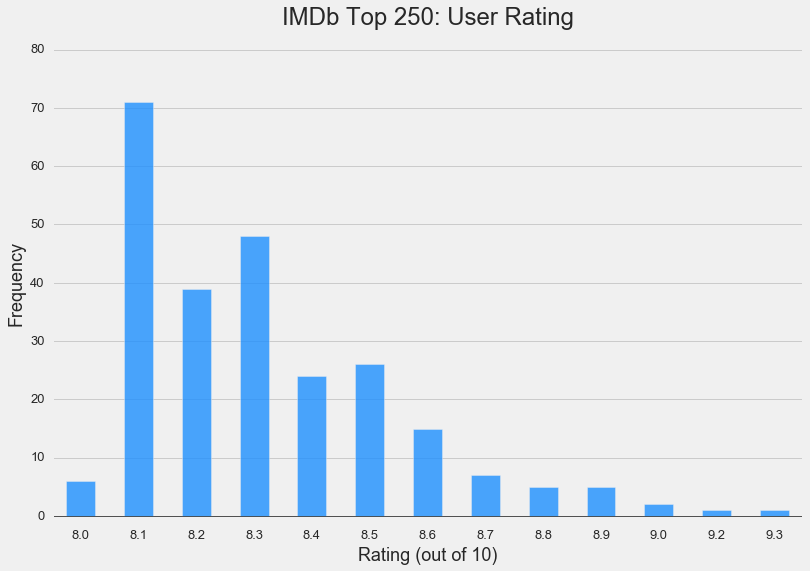

In [55]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

ratings = pd.DataFrame(top['rating'].value_counts())
ratings.sort_index(inplace = True)
ratings['rating'].plot.bar(color = 'dodgerblue', alpha = 0.8)

plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.title('IMDb Top 250: User Rating', fontsize = 24, y = 1.03)

# y label
plt.yticks(range(0, 85, 10), fontsize = 13)
plt.ylabel('Frequency', fontsize = 18)

# x label
plt.xticks(rotation = 0, fontsize = 13)
plt.xlabel('Rating (out of 10)', fontsize = 18)

#plt.xlim([min(top['rating']), 10])
plt.ylim([-1, 81])

#plt.legend(loc='upper right', fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

Is index number random?  Very clearly not, from this plot of index number vs. user rating: 

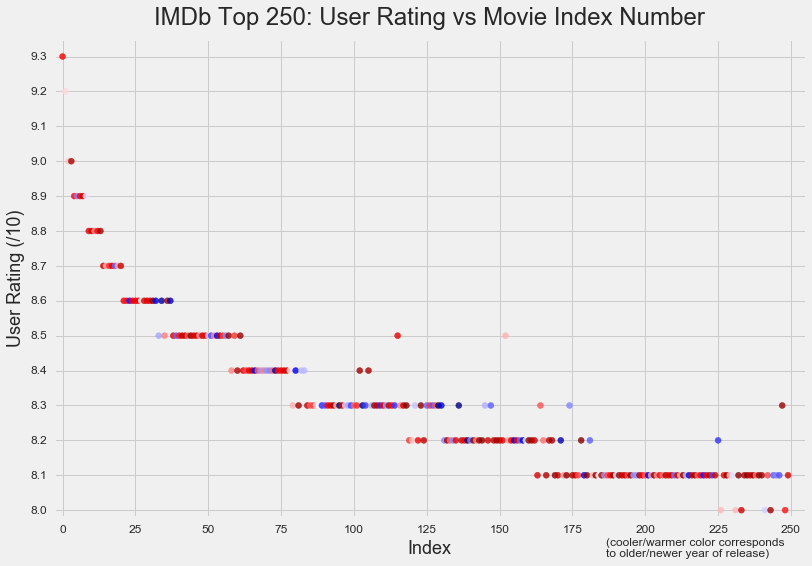

In [56]:
top_year_color = []
for i in top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
top['top_year_color'] = top_year_color

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

s = plt.scatter(top.index, top['rating'], color = top['top_year_color'], s = 35, alpha = 0.8)
plt.axhline(0, color='black', alpha = 0.6)
plt.title('IMDb Top 250: User Rating vs Movie Index Number', fontsize = 24, y = 1.02)

# y label
plt.ylabel('User Rating (/10)', fontsize = 18)
plt.yticks([8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3], \
           fontsize = 12)

# x label
plt.xlabel('Index', y = 0.1, fontsize = 18)
plt.xticks(range(0, 275, 25), fontsize = 12)

plt.xlim([-3, len(top) + 5])
plt.ylim([7.98, 9.35])

# cb = plt.colorbar(mappable = s)
# cb.set_label('Cbar Label Here')

plt.annotate('(cooler/warmer color corresponds \nto older/newer year of release)', 
             (1,0), (-200, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 12)

plt.show()

What's up with those outliers?  Looks like it should be slightly-overlapping steps moving downward in negative direction from index 0 to 249.  We'll consider taking these out of the data set because they are clearly exceptions to the general trend of user rating being negatively correlated with index number.  Let's look at some boxplots:

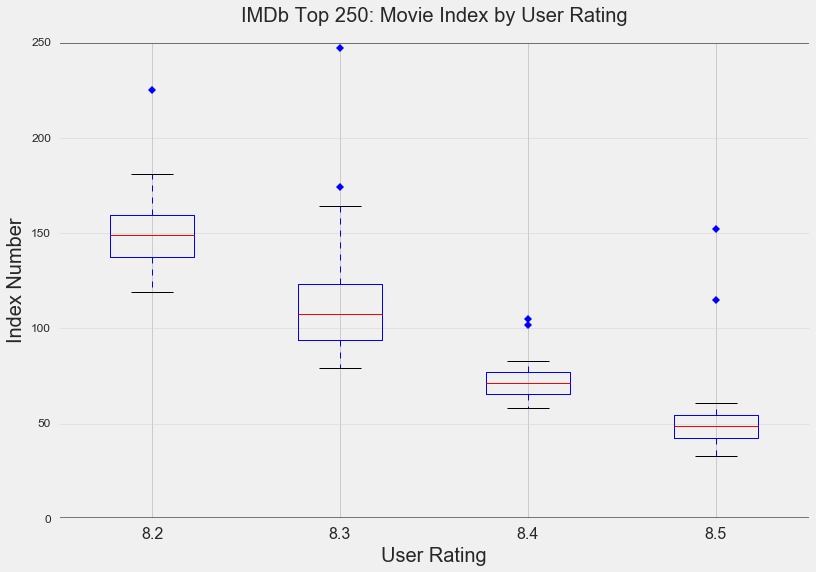

In [57]:
data = [top[top['rating'] == 8.2].index, top[top['rating'] == 8.3].index, \
        top[top['rating'] == 8.4].index, top[top['rating'] == 8.5].index]
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

bp = plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('IMDb Top 250: Movie Index by User Rating', y =1.03)
ax1.set_xlabel('User Rating', fontsize = 20)
ax1.set_ylabel('Index Number', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = 4
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(0, 251)
xtickNames = plt.setp(ax1, xticklabels=['8.2', '8.3', '8.4', '8.5'])
plt.setp(xtickNames, fontsize=16)
ytickNames = plt.setp(ax1, yticklabels=range(0, 300, 50))
plt.setp(ytickNames, fontsize=12)

plt.axhline(0, color='black', alpha = 0.5)
plt.axhline(250, color='black', alpha = 0.5, linewidth = 1)

plt.show()

Which movies are these outliers? 

In [58]:
top[(top['rating'] == 8.5) & (top.index > 100)][['title', 'year', 'rating']]

,title,year,rating
115,Children of Heaven,1997,8.5
152,The Message,1976,8.5


In [59]:
top[(top['rating'] == 8.4) & (top.index > 95)][['title', 'year', 'rating']] 

,title,year,rating
102,A Separation,2011,8.4
105,3 Idiots,2009,8.4


In [60]:
top[(top['rating'] == 8.3) & (top.index > 150)][['title', 'year', 'rating']]

,title,year,rating
164,Come and See,1985,8.3
174,Nights of Cabiria,1957,8.3
247,Gangs of Wasseypur,2012,8.3


In [61]:
top[(top['rating'] == 8.2)][['title', 'year', 'rating']].tail(1)

,title,year,rating
225,Kind Hearts and Coronets,1949,8.2


Hm, they seem mostly foreign just by eyeballing.  We're probably justified in removing them because the box and whisker plots suggest they are true outliers, but we'll keep them in for now as we poke around a little more.

In [62]:
top['year'].describe()

count     250.000000
mean     1984.028000
std        24.152361
min      1921.000000
25%      1964.000000
50%      1991.000000
75%      2003.750000
max      2016.000000
Name: year, dtype: float64

In the histogram below, each bar slot represents one year:

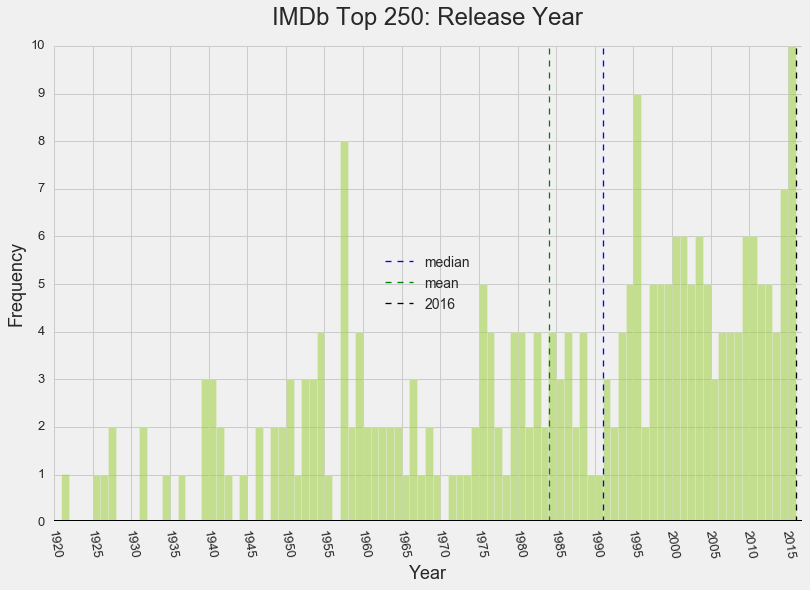

In [89]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['year'], color = 'yellowgreen', alpha = 0.5, bins = 95)
plt.axvline(top['year'].median(), color='b', linestyle='dashed', linewidth=1.3, \
            label = 'median')
plt.axvline(top['year'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axvline(2016, color='black', linestyle='dashed', linewidth=1.3, label = '2016')
plt.axhline(0, color='black')
plt.title('IMDb Top 250: Release Year', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Frequency', fontsize = 18)
plt.yticks(range(0, 11, 1), fontsize = 13)

# x label
plt.xlabel('Year', fontsize = 18)
plt.xticks(range(1920, 2016, 5), fontsize = 13, rotation = -80)

plt.xlim([min(top['year']) - 1.3, max(top['year']) + 1])
plt.ylim([0, 10.04])

plt.legend(loc='center', fontsize = 14)

plt.show()

1957 was a good year:

In [90]:
top[top['year'] == 1957][['title', 'num_votes']]

,title,num_votes
5,12 Angry Men,444537
56,Paths of Glory,120296
71,Witness for the Prosecution,62644
131,The Bridge on the River Kwai,148511
134,The Seventh Seal,111224
140,Wild Strawberries,62751
174,Nights of Cabiria,25670
245,Throne of Blood,31534


As was 1995:

In [91]:
top[top['year'] == 1995][['title', 'num_votes']]

,title,num_votes
21,Se7en,1017162
24,The Usual Suspects,736650
75,Braveheart,732761
91,Toy Story,619286
122,Heat,429218
138,Casino,331585
205,Before Sunrise,181895
219,Twelve Monkeys,460419
227,La Haine,102825


The spike farthest to the right on the histogram is combined 2015 and 2016-to-date:

In [92]:
top[(top['year'] == 2015) | (top['year'] == 2016)][['title', 'year']]

,title,year
118,Inside Out,2015
123,Room,2015
141,Star Wars: The Force Awakens,2015
160,Captain America: Civil War,2016
178,Zootopia,2016
180,Spotlight,2015
183,Mad Max: Fury Road,2015
203,Deadpool,2016
213,The Revenant,2015
232,The Martian,2015


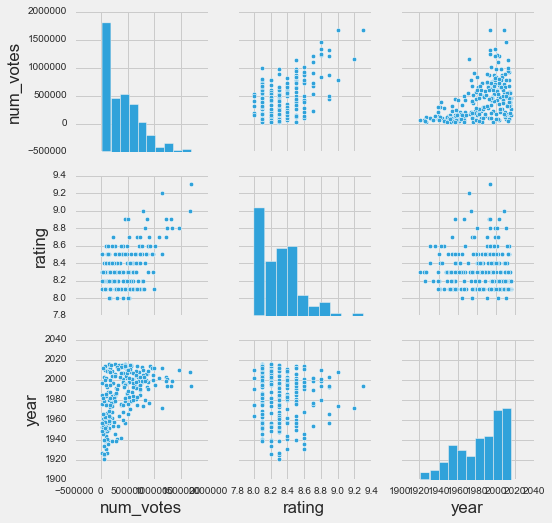

In [93]:
sns.pairplot(top[['num_votes', 'rating', 'year']])

Let's dig a little deeper into these...

#### Create list of areas proportionate to each movie's user rating:

In [94]:
rating_area = []
for rating in top['rating']:
    new_rating = (((300 - 10)*(rating - min(top['rating']))) / \
                  (max(top['rating'] - min(top['rating'])))) + 10
    rating_area.append(new_rating)

#### Create list of areas proportionate to each movie's year of release:

In [95]:
year_area = []
for year in top['year']:
    new_year = (((100 - 5)*(year - min(top['year'])) ) / \
                (max(top['year'] - min(top['year'])))) + 5
    year_area.append(new_year)

#### Create a list of areas proportionate to each movie's index number in the Top 250 list:

In [96]:
index_area = []
for index in top.index:
    new_index = 200 - (((200 - 5)*(index - min(top.index))) / \
                  (max(top.index - min(top.index)))) + 5
    index_area.append(new_index)

#### Use a jitter function to distinguish points plotted at discrete intervals:

In [97]:
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=30, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, \
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, \
           norm=norm, vmin=vmin, vmax=vmax, alpha=0.5, linewidths=linewidths, verts=verts, \
           hold=hold, **kwargs)

## jitter assistance from:
## http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-\
## in-a-scatter-dot-beeswarm-plot

The plot below suggests that the more votes a movie has, the higher its rating will be.  We see that older movies tend to have fewer votes.  Also, the spread in older movies' ratings is smaller and the average rating appears lower. 

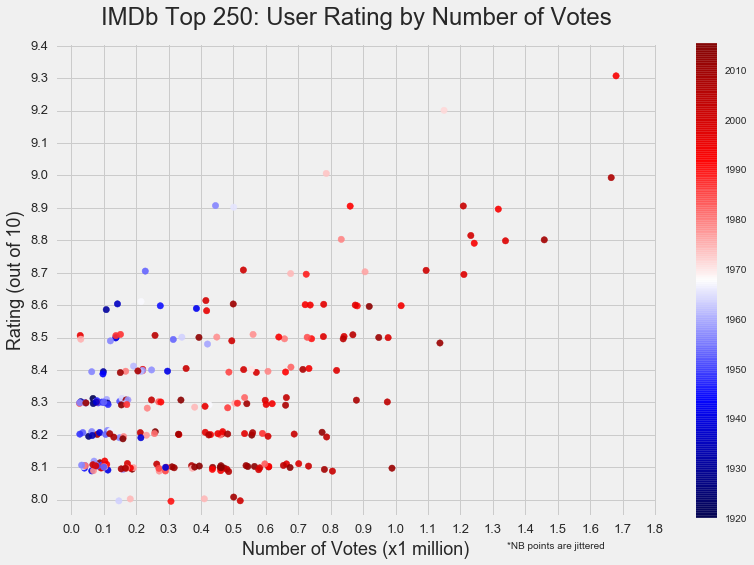

In [155]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

top_year_color = []
for i in top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
top['top_year_color'] = top_year_color

plt.scatter(top['num_votes']/1000000, rand_jitter(top['rating']), \
            color = top['top_year_color'], alpha = 0.9, s = 40) #can change to s = index_area


plt.title('IMDb Top 250: User Rating by Number of Votes', fontsize = 24, y = 1.03)
plt.axhline(0, color='darkblue', alpha = 0.5)
# y label
plt.ylabel('Rating (out of 10)', fontsize = 18)
plt.yticks(np.arange(8.0, 9.5, 0.1), fontsize = 13)

# x label
plt.xlabel('Number of Votes (x1 million)', fontsize = 18)
plt.xticks(np.arange(0.0, 1.81, 0.1), fontsize = 13)

# set the figure boundaries
plt.xlim([-0.05, 1.805])
plt.ylim([7.95, 9.407])
plt.grid(True)

plt.annotate('*NB points are jittered', (1,0), (-150, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 10)

img = plt.imshow(np.array([[1920,2016]]), cmap="seismic", alpha = 0.85)
img.set_visible(False)
plt.colorbar()

plt.show()

In [156]:
top[(top['rating'] >= 8.8) & (top['num_votes'] > 1250000)][['title', 'num_votes', 'rating']]

,title,num_votes,rating
0,The Shawshank Redemption,1680129,9.3
3,The Dark Knight,1665144,9.0
6,Pulp Fiction,1316868,8.9
9,Fight Club,1339026,8.8
13,Inception,1458647,8.8


Let's use an API to get whatever else we can:

In [157]:
# certification = []
# for movie in top['tconst']:
#     time.sleep(0.25)
#     title = imdb.get_title_by_id(movie)
#     cert = title.certification
#     certification.append(cert)
# print 'done collecting!'
# certification = pd.DataFrame(certification)
# certification.to_csv('../IMDb Top 250/assets/certification.csv', index = False, \
# encoding = 'utf-8')

In [159]:
certification = pd.read_csv('../IMDb_Top_250/assets/certification.csv')
certification.columns = ['cert']
top['cert'] = certification
top['cert'].value_counts()

R            92
Not Rated    33
PG           32
PG-13        30
Approved     14
Unrated      12
G            10
TV-PG         9
TV-14         6
TV-MA         4
Passed        3
M             2
X             1
TV-G          1
E             1
Name: cert, dtype: int64

Ew!  Let's consolidate.  This cell prints all movies not having 'R', 'PG-13', 'PG', or 'G' as a certification, which is a long list for which we checked/updated every observation:

In [160]:
# cert_OK = ['R', 'PG-13', 'PG', 'G']
# for i in range(len(top['cert'])):
#     if top['cert'][i] in cert_OK:
#         print '.',
#     else:
#         print '\n'
#         print top.loc[i][['title', 'cert']]

In [161]:
# top['cert'][101] = 'PG-13' # Indiana Jones and the Last Crusade
# top['cert'][91] = 'G' # Toy Story
# top['cert'][78] = 'R' # A Clockwork Orange
# top['cert'][34] = 'G' # City Lights
# top['cert'][80] = 'Not Rated' # Double Indemnity
# top['cert'][215] = 'G' # Wizard of Oz 
# top['cert'][27] = 'PG-13' # Once Upon a Time in the West
# top['cert'][241] = 'R' # A Fistful of Dollars
# top['cert'][9] = 'R' # Fight Club
# top['cert'][29] = 'R' # Saving Private Ryan
# top['cert'][74] = 'R' # Reservoir Dogs
# top['cert'][96] = 'R' # L.A. Confidential
# top['cert'][30] = 'R' # American History X
# top['cert'][40] = 'R' # Terminator 2: Judgment Day
# top['cert'][52] = 'R' # Alien
# top['cert'][64] = 'PG-13' # Princess Mononoke
# top['cert'][100] = 'R' # Scarface
# top['cert'][145] = 'Not Rated' # Judgment at Nuremberg
# top['cert'][18] = 'Not Rated' # Seven Samurai
# top['cert'][26] = 'R' # Léon: The Professional
# top['cert'][59] = 'Not Rated' # Grave of the Fireflies
# top['cert'][77] = 'R' # Requiem for a Dream
# top['cert'][99] = 'Not Rated' # Rashomon
# top['cert'][106] = 'Not Rated' # Yojimbo
# top['cert'][139] = 'Not Rated' # The General
# top['cert'][140] = 'Not Rated' # Wild Strawberries
# top['cert'][171] = 'Not Rated' # It Happened One Night
# top['cert'][209] = 'Not Rated' # Diabolique
# top['cert'][210] = 'Not Rated' # Memories of Murder
# top['cert'][245] = 'Not Rated' # Throne of Blood
# top['cert'][32] = 'PG' # Casablanca
# top['cert'][104] = 'Approved' # All About Eve
# top['cert'][109] = 'Not Rated' # The Treasure of the Sierra Madre
# top['cert'][137] = 'PG' # Howl's Moving Castle
# top['cert'][158] = 'G' # Gone With the Wind
# top['cert'][196] = 'G' # Ben-Hur
# top['cert'][216] = 'G' # Monsters, Inc.
# top['cert'][223] = 'PG' # Strangers on a Train
# top['cert'][242] = 'PG' # Castle in the Sky
# top['cert'][23] = 'PG' # It's a Wonderful Life
# top['cert'][33] = 'R' # Psycho
# top['cert'][39] = 'PG' # Rear Window
# top['cert'][50] = 'PG' # Dr. Strangelove
# top['cert'][70] = 'PG' # Vertigo
# top['cert'][131] = 'PG' # Bridge on the River Kwai

In [162]:
# certification = pd.DataFrame(top['cert'])
# certification.to_csv('../IMDb Top 250/assets/certification2.csv', index = False, \
# encoding = 'utf-8')

In [163]:
certification = pd.read_csv('../IMDb_Top_250/assets/certification2.csv')
certification.columns = ['cert']
top['cert'] = certification

Much nicer:

In [164]:
top['cert'].value_counts()

R            105
Not Rated     46
PG            41
PG-13         33
G             16
Approved       9
Name: cert, dtype: int64

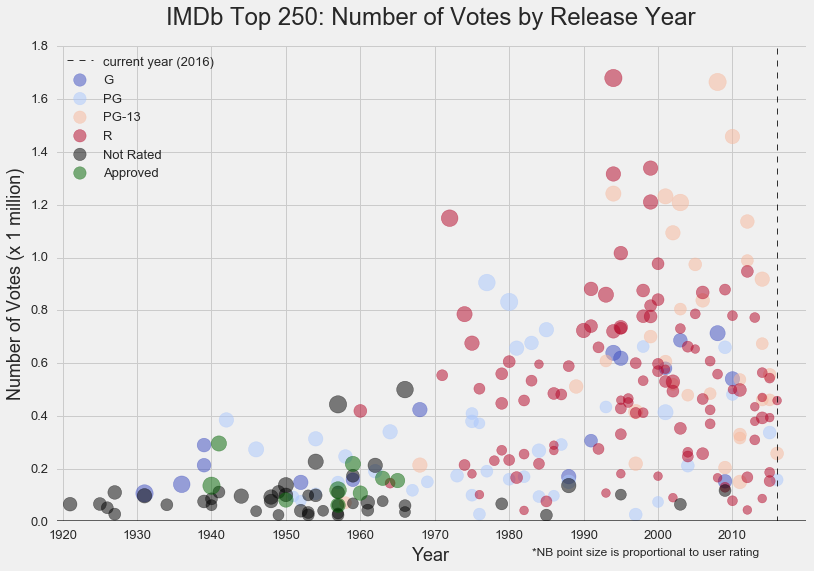

In [276]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))
del cert

cert_dict['Not Rated'] = 'black'
cert_dict['Approved'] = 'darkgreen'

# set area of dot proportional-ish to rating
area = rating_area

plot_order = ['G', 'PG', 'PG-13', 'R', 'Not Rated', 'Approved']

for i in plot_order:
    y = top[top['cert'] == i]
    plt.scatter(y['year'], y['num_votes']/1000000, color = cert_dict[i], alpha = 0.5, \
                s = area, label = i)

plt.title('IMDb Top 250: Number of Votes by Release Year', fontsize = 24, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, \
            label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)', fontsize = 18)
plt.yticks(np.arange(0, 1.9, 0.2), fontsize = 13)

# x label
plt.xlabel('Year', fontsize = 18)
plt.xticks(range(1920, 2020, 10), fontsize = 13)

# set the figure boundaries
plt.xlim([1919, 2020])
plt.ylim([0, 1.81])

plt.grid(True)
plt.legend(loc='upper left', fontsize = 13)
plt.annotate('*NB point size is proportional to user rating', (1,0), (-275, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)


plt.show()

What's the red dot outlier in the 1970s up high?  The Godfather?  From the 1990s onward, there does seem to be a drastic increase in the number of votes; this probably has to do with the invention of the internet, popularity increase of IMDb, etc.  There is no evidence that average movie quality is itself increasing, however... there are just a lot more people watching movies and using the internet/social media.  The growth starts in the 1970s, though.  This was a turning point in American movies as the MPAA changed its audience viewing codes.

("In 1968, after several years of minimal enforcement, the outdated Production Code was replaced by the MPAA film rating system." https://en.wikipedia.org/wiki/Motion_Picture_Production_Code)

In [186]:
top[(top['year'] < 1980) & (top['num_votes'] > 1000000)][['title', 'rating', 'year', \
                                                          'num_votes']]

,title,rating,year,num_votes
1,The Godfather,9.2,1972,1149482


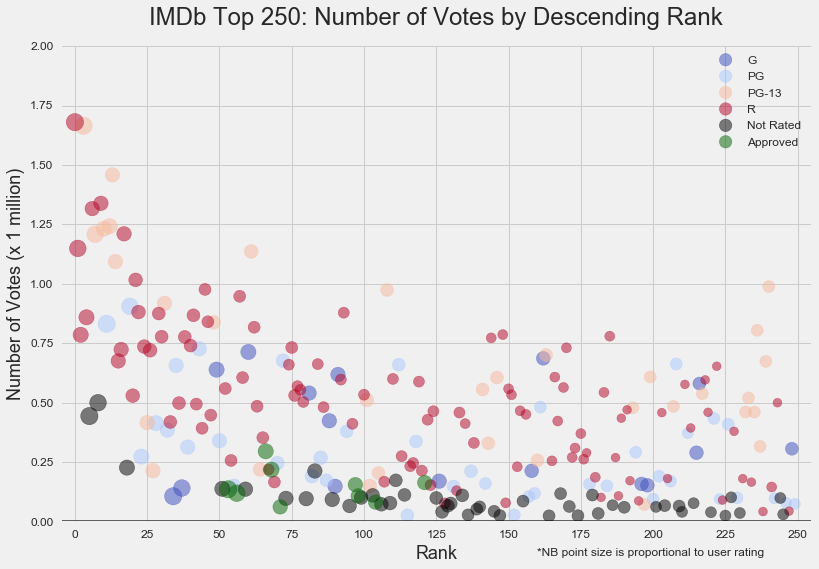

In [205]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in plot_order:
    y = top[top['cert'] == i]
    plt.scatter(y.index, y['num_votes']/1000000, color = cert_dict[i], alpha = 0.5, \
                s = area, label = i)

plt.title('IMDb Top 250: Number of Votes by Descending Rank', fontsize = 24, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)

# y label
plt.ylabel('Number of Votes (x 1 million)', fontsize = 18)
plt.yticks(np.arange(0, 2.25, 0.25), fontsize = 12)


# x label
plt.xlabel('Rank', fontsize = 18)
plt.xticks(np.arange(0, 275, 25), fontsize = 12)

# set the figure boundaries
plt.xlim(-5, 255)
plt.ylim([0, 2.01])

plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)
plt.annotate('*NB point size is proportional to user rating', (1,0), (-275, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

Again, from this plot it is clear that the index contains information (i.e., it is the site's rank of the movie).  We also see that: higher-ranked movies tend to have more votes; MPAA certifications are pretty uniformly distributed across the ranking; 'R' and 'PG-13' tend to get more votes than 'G' and 'PG', and certainly more than 'Not Rated' and 'Approved' (the latter of which was only given in the USA and no longer exists).  There also appears to be a positive correlation between lower index number (higher ranking) and number of votes.

OK!  Now let's scrape some more data:

In [206]:
# URL = 'http://www.imdb.com/title/'
# paths = top['tconst']
# soup = []
# for i in paths:
#     time.sleep(1)
#     request = requests.get(URL + i + '/')
#     if str(request) != '<Response [200]>':
#         print URL + i + '/'
#     tiny_soup = BeautifulSoup(request.content, "lxml")
#     soup.append(tiny_soup)

# print 'done scraping!  pickle time.'
# cPickle.dump(soup, open('movie_soup2.p', 'wb')) 

In [207]:
# soup = cPickle.load(open('../IMDb Top 250/assets/movie_soup2.p', 'rb'))

In [208]:
# running_time = []
# for i in range(len(soup)):
#     times = []
#     for j in soup[i].find_all('time', itemprop = 'duration'):
#         times.append(j.text.encode('utf8'))
#     running_time.append(times[0])

# for i in range(len(running_time)):
#     split_time = []
#     clean_time = running_time[i].replace('\n                        ', '')
#     clean_time = clean_time.replace('min\n                    ', '')
#     split_time = clean_time.split('h ')
#     split_time[0] = split_time[0].replace('h\n                    ', '')
#     if len(split_time) == 1:
#         minutes = float(split_time[0]) * 60
#         running_time[i] = int(minutes) 
#     else:
#         minutes = float(split_time[0]) * 60 + float(split_time[1])
#         running_time[i] = int(minutes)
        
# run_time = pd.DataFrame(running_time, columns = ['run_time'])
# run_time.to_csv('../IMDb Top 250/assets/run_time.csv', index = False)

Load running time file and add as column to data frame:

In [210]:
run_time = pd.read_csv('../IMDb_Top_250/assets/run_time.csv')
top['run_time'] = run_time

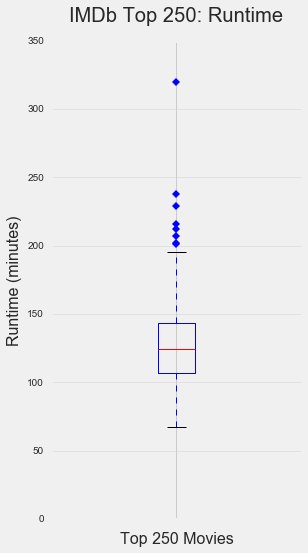

In [213]:
data = top['run_time']
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(4, 8))
fig.canvas.set_window_title('')


plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('IMDb Top 250: Runtime', y =1.03)
ax1.set_xlabel('Top 250 Movies', fontsize = 16)
ax1.set_ylabel('Runtime (minutes)', fontsize = 16)

# Set the axes ranges and axes labels
numBoxes = 1
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(0, 350)
xtickNames = plt.setp(ax1, xticklabels = '')
plt.setp(xtickNames, fontsize=14)

plt.show()

In [214]:
top['run_time'].describe()

count    250.000000
mean     128.628000
std       32.104398
min       67.000000
25%      107.000000
50%      124.000000
75%      143.000000
max      320.000000
Name: run_time, dtype: float64

In [215]:
top[top['run_time'] > 198][['title', 'year', 'rating', 'num_votes', 'run_time']]

,title,year,rating,num_votes,run_time
2,The Godfather: Part II,1974,9.0,786145,202
7,The Lord of the Rings: The Return of the King,2003,8.9,1208872,201
18,Seven Samurai,1954,8.7,227856,207
67,Once Upon a Time in America,1984,8.4,219675,229
82,Lawrence of Arabia,1962,8.4,191695,216
158,Gone with the Wind,1939,8.2,214233,238
196,Ben-Hur,1959,8.1,159197,212
247,Gangs of Wasseypur,2012,8.3,44802,320


Wow, Gangs of Wasseypur is super long... let's keep it in for now, we may take it out later.  Other ones are not as far away from the mean; we'll keep them.

In [216]:
# genre = []
# for i in range(len(soup)):
#     genres = []
#     for j in soup[i].find_all('span', itemprop = 'genre'):
#         genres.append(j.text.encode('utf8'))
#     genre.append(genres)

# for i in range(len(genre)):
#     genre[i] = str(genre[i])
    
# genre = pd.DataFrame(genre, columns = ['genre'])
# genre.to_csv('../IMDb Top 250/assets/genre.csv', index = False)

Load genre file and add as column to data frame:

In [217]:
genre = pd.read_csv('../IMDb_Top_250/assets/genre.csv')
genre.columns = ['genre']
top['genre'] = genre

In [218]:
# release_info = []
# for i in range(len(soup)):
#     info = []
#     for j in soup[i].find_all('a', title = 'See more release dates'):
#         info.append(j.text.encode('utf8'))
#     release_info.append(info)

# month = []
# country = []
# for i in range(len(release_info)):
#     month_country = []
#     release_info[i] = str(release_info[i])
#     clean = release_info[i].replace(')\\n\\n\']', '')
#     split = clean.split(' ')
#     if len(split) == 4:
#         month.append(split[1])
#         split[3] = split[3].replace('(', '')
#         country.append(split[3])
#     else:
#         month.append(split)
#         country.append(split)

# all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
# 'August', 'September', 'October', \
#              'November', 'December']

# top['month'] = month
# top['country'] = country
# for i in range(len(top)):
#     if top['month'][i] in all_months:
#         print '.',
#     else:
#         print '\n'
#         print top.loc[i][['title', 'month', 'country']]
#         print '\n'

Correct the ones that came through in different format and look up month for 'The Gold Rush' (thanks, Wikipedia!):

In [219]:
# top['month'][5] = 'April'
# top['country'][5] = 'USA'
# top['month'][56] = 'October'
# top['country'][56] = 'West Germany'
# top['month'][65] = 'November'
# top['country'][65] = 'South Korea'
# top['month'][129] = 'June'
# top['country'][129] = 'Germany'
# top['month'][209] = 'May'
# top['country'][209] = 'South Korea'
# top['month'][224] = 'December'
# top['country'][224] = 'Hong Kong'

In [220]:
# month = pd.DataFrame(top['month'], columns = ['month'])
# country = pd.DataFrame(top['country'], columns = ['country'])
# month.to_csv('../IMDb Top 250/assets/month.csv', \
# index = False, encoding = 'utf-8')
# country.to_csv('../IMDb Top 250/assets/country.csv', \
# index = False, encoding = 'utf-8')

Load month and country files and add as columns to data frame:

In [221]:
month = pd.read_csv('../IMDb_Top_250/assets/month.csv')
country = pd.read_csv('../IMDb_Top_250/assets/country.csv')
top['month'] = month
top['country'] = country
top['month'].value_counts()

December     29
February     24
June         23
March        23
January      21
October      21
May          20
November     20
August       19
July         18
September    17
April        15
Name: month, dtype: int64

Now, let's make a bar chart of month of release:

In [222]:
y = pd.DataFrame(top['month'].value_counts())
y.columns = ['count']
y['month'] = y.index
y = y.reset_index(drop = True)
order = range(12)
all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', \
              'September', 'October', 'November', 'December']
month_dict = dict(zip(all_months, order))
y['order'] = y['month'].apply(lambda x: month_dict[x])
y = y.sort('order')
del y['order']
y = y.set_index(y['month'], drop = False)
del y['month']

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


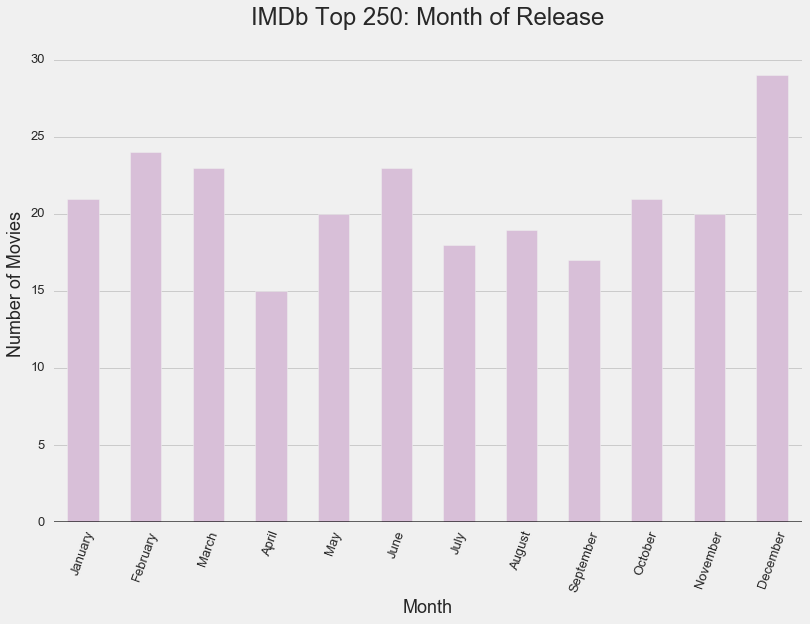

In [227]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y['count'].plot.bar(color = 'thistle')

plt.title('IMDb Top 250: Month of Release', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Number of Movies', fontsize = 18)
plt.yticks(range(0, 35, 5), fontsize = 13)
plt.ylim([0, 31])

# x label
plt.xlabel('Month', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.show()

Nothing terribly non-intuive here; there are summer movies, there are winter/holiday movies, not a lot coming out in April and September.

Let's check out where non-USA, non-UK movies are from:

In [228]:
top[(top['country'] != 'USA') & (top['country'] != 'UK')][['title', 'country']]

,title,country
36,The Intouchables,France
44,Whiplash,Philippines
51,Sunset Blvd.,Australia
56,Paths of Glory,West Germany
59,Grave of the Fireflies,Japan
64,Princess Mononoke,Japan
65,Oldboy,South Korea
68,North by Northwest,Japan
70,Vertigo,Brazil
73,M,Sweden


A lot of these look weird... Hitchcock in Japan and Brazil?  Reservoir Dogs in France?  Maybe they're release locations?  Let's try to scrape country of origin separately and keep this as-is for now.

In [229]:
# origin = []
# for i in range(len(soup)):
#     country = []
#     for j in soup[i].find_all('a', href = re.compile('/country/')):
#         country.append(j.text.encode('utf8'))
#     if len(country) > 1:
#         mini_list = []
#         mini_list.append(country[0])
#         origin.append(mini_list)
#     else:
#         origin.append(country)

# origin = pd.DataFrame(origin)
# origin.to_csv('../IMDb Top 250/assets/origin.csv', index = False)

Load country of origin (we hope!) file and add as column to the data frame:

In [230]:
origin = pd.read_csv('../IMDb_Top_250/assets/origin.csv')
top['origin'] = origin

Let's print all observations where 'country' does not match 'origin': (commented out, too long)

In [231]:
# for i in range(len(top)):
#     if top['country'][i] != top['origin'][i]:
#         print top.loc[i][['title', 'country', 'origin']]
#         print '\n'

Neither list is correct on every observation, so let's change 'country' to be the one we keep:

In [232]:
# top['country'][206] = 'UK'
# top['country'][214] = 'Italy'
# top['country'][220] = 'USA'
# top['country'][225] = 'UK'
# top['country'][227] = 'France'
# top['country'][229] = 'USA'
# top['country'][230] = 'Italy'
# top['country'][234] = 'Hong Kong'
# top['country'][241] = 'Italy'
# top['country'][243] = 'UK'
# top['country'][245] = 'Japan'
# top['country'][247] = 'India'
# top['country'][249] = 'Hong Kong'
# top['country'][139] = 'USA'
# top['country'][140] = 'Sweden'
# top['country'][145] = 'USA'
# top['country'][147] = 'Japan'
# top['country'][149] = 'Canada'
# top['country'][152] = 'Lebanon'
# top['country'][154] = 'UK'
# top['country'][164] = 'Russia' # SOVIET UNION!
# top['country'][172] = 'UK'
# top['country'][181] = 'France' # and italy!
# top['country'][186] = 'France'
# top['country'][188] = 'Ireland'
# top['country'][190] = 'Sweden'
# top['country'][192] = 'Mexico'
# top['country'][196] = 'USA'
# top['country'][197] = 'USA'
# top['country'][204] = 'Russia' # SOVIET UNION!
# top['country'][104] = 'USA'
# top['country'][106] = 'Japan'
# top['country'][111] = 'USA'
# top['country'][115] = 'Iran'
# top['country'][117] = 'Germany'
# top['country'][123] = 'Ireland'
# top['country'][124] = 'Spanish'
# top['country'][127] = 'Japan'
# top['country'][129] = 'USA'
# top['country'][134] = 'Sweden'
# top['country'][137] = 'Japan'
# top['country'][70] = 'USA'
# top['country'][73] = 'Germany'
# top['country'][74] = 'USA'
# top['country'][76] = 'France'
# top['country'][87] = 'USA'
# top['country'][89] = 'Italy'
# top['country'][92] = 'UK'
# top['country'][97] = 'Italy'
# top['country'][98] = 'USA'
# top['country'][99] = 'Japan'
# top['country'][103] = 'Germany'
# top['country'][8] = 'Italy'
# top['country'][18] = 'Japan'
# top['country'][20] = 'Brazil'
# top['country'][25] = 'Italy'
# top['country'][26] = 'France'
# top['country'][27] = 'Italy'
# top['country'][28] = 'Japan'
# top['country'][39] = 'USA'
# top['country'][42] = 'France'
# top['country'][44] = 'USA'
# top['country'][51] = 'USA'
# top['country'][54] = 'Germany'
# top['country'][55] = 'Italy'
# top['country'][56] = 'USA'
# top['country'][68] = 'USA'
# top['country'][69] = 'Germany' # WEST Germany!

In [260]:
# country = pd.DataFrame(top['country'])
# country.to_csv('../IMDb Top 250/assets/country2.csv', index = False, \
#                encoding = 'utf-8')

In [233]:
country = pd.read_csv('../IMDb_Top_250/assets/country2.csv')
top['country'] = country

In [234]:
del top['origin']

Get director name (only take first if more than one):

In [235]:
# director = []
# for i in range(len(soup)):
#     dirs = []
#     for j in soup[i].find_all('span', itemprop = 'director'):
#         for k in j.find_all('span', itemprop = 'name'):
#             dirs.append(k.text.encode('utf8'))
# # these two lines will print all directors' names for movies with more than one director listed
# #            if len(dirs) != 1:
# #                print dirs
#     if len(dirs) > 1:
#         mini_list = []
#         mini_list.append(dirs[0])
#         director.append(mini_list)
#     else:
#         director.append(dirs)
        
# len(director)

In [236]:
# director = pd.DataFrame(director)
# director.to_csv('../IMDb Top 250/assets/director.csv', index = False)

Note: some director observations had two names listed; only the first one was kept for the data set.  The second names tended to say "uncredited" after them and were never the main director.

In [237]:
director = pd.read_csv('../IMDb_Top_250/assets/director.csv')
top['director'] = director

Surprise!  There are no female directors with more than two movies in the Top 250 list:

In [238]:
dir_count = pd.DataFrame(top['director'].value_counts())
dir_count.columns = ['count']
dir_count = dir_count[dir_count['count'] > 2]
dir_count

,count
Stanley Kubrick,7
Steven Spielberg,7
Alfred Hitchcock,7
Christopher Nolan,7
Martin Scorsese,7
Akira Kurosawa,6
Hayao Miyazaki,6
Sergio Leone,5
Charles Chaplin,5
Billy Wilder,5


We'll make dummy variables for these prolific directors later.

### Foreign vs Domestic:

From the MPAA certification-colored scatter plot, we can tell there is definitely something going on with 'Not Rated' and 'Approved' MPAA certifications with respect to year of release.  Let's investigate.

In [239]:
foreign_notNR = top[(top['cert'] != 'Not Rated') & (top['country'] != 'USA')]

foreign_NR = top[(top['cert'] == 'Not Rated') & (top['country'] != 'USA')]

domestic_notNR = top[(top['cert'] != 'Not Rated') & (top['country'] == 'USA')]

domestic_NR = top[(top['cert'] == 'Not Rated') & (top['country'] == 'USA')]

Most 'Not Rated' and 'Approved' movies in the list are pre-1970; after 1970, almost all of the 'Not Rated' movies are non-USA.  

In [240]:
x = float(len(foreign_notNR))/ (len(foreign_notNR) + len(foreign_NR))

print 'Proportion of non-\'Not Rated\' foreign films to \'Not Rated\' foreign films \
post-1970: %s' %round(x, 3)

Proportion of non-'Not Rated' foreign films to 'Not Rated' foreign films post-1970: 0.644


Additionally, all domestic films since 1970 are non-'Not Rated':

In [241]:
y = float(len(domestic_notNR[domestic_notNR['year'] > 1970]))/len(top[(top['country'] == \
                                                            'USA') & (top['year'] > 1970)])

print 'Proportion of non-\'Not Rated\' domestic films to \'Not Rated\' domestic films \
post-1970: %s' %round(y, 3)

Proportion of non-'Not Rated' domestic films to 'Not Rated' domestic films post-1970: 1.0


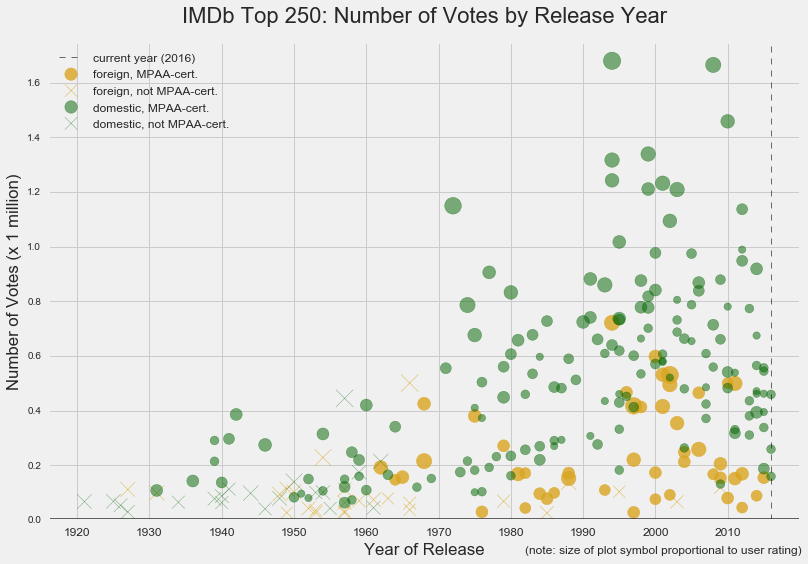

In [242]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')


# set area of dot proportional-ish to rating
area = rating_area

# plot number of votes by year of release
plt.scatter(foreign_notNR['year'], foreign_notNR['num_votes']/1000000, \
            color = 'GoldenRod', marker = 'o', alpha = 0.8, s = area, \
            label = 'foreign, MPAA-cert.')
plt.scatter(foreign_NR['year'], foreign_NR['num_votes']/1000000, \
            color = 'GoldenRod', marker = 'x', alpha = 0.8, s = area, \
            label = 'foreign, not MPAA-cert.')
plt.scatter(domestic_notNR['year'], domestic_notNR['num_votes']/1000000, \
            color = 'darkgreen', marker = 'o', alpha = 0.5, s = area, \
            label = 'domestic, MPAA-cert.')
plt.scatter(domestic_NR['year'], domestic_NR['num_votes']/1000000, \
            color = 'darkgreen', marker = 'x', alpha = 0.5, s = area, \
            label = 'domestic, not MPAA-cert.')

plt.title('IMDb Top 250: Number of Votes by Release Year', fontsize = 22, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, alpha = 0.7, \
            label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')
plt.xticks(range(1920, 2020, 10), fontsize = 12)

# set the figure boundaries
plt.xlim([min(top['year']) - 5, 2020])
plt.ylim([0, 1.75])

plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('(note: size of plot symbol proportional to user rating)', (1,0), \
             (-275, -25), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 12)
plt.show()

What is the most recently released USA movie that had no MPAA rating ('cert')?

In [243]:
domestic_NR[['title', 'year']].head(1)

,title,year
5,12 Angry Men,1957


What's the highest-rated foreign movie?

In [244]:
top[top['country'] != 'USA'].head(1)[['title', 'year', 'country']]

,title,year,country
8,"The Good, the Bad and the Ugly",1966,Italy


Since the most recent 'Not Rated' domestic movie was 1962, let's check which one there have been since then:

In [245]:
top[(top['country'] != 'USA') & (top['cert'] == 'Not Rated') & (top['year'] > 1962)]\
[['title', 'year', 'country']]

,title,year,country
8,"The Good, the Bad and the Ugly",1966,Italy
59,Grave of the Fireflies,1988,Japan
164,Come and See,1985,Russia
168,Mary and Max,2009,Australia
190,Persona,1966,Sweden
204,Stalker,1979,Russia
209,Memories of Murder,2003,South Korea
214,8½,1963,Italy
227,La Haine,1995,France
230,The Battle of Algiers,1966,Italy


### Time to make dummies!

In [246]:
cv = CountVectorizer()
data = cv.fit_transform(top['genre']).todense()
columns = [c for c in cv.get_feature_names()]
dumbgenre = pd.DataFrame(data, columns=columns)

In [247]:
dumbgenre.columns

Index([u'action', u'adventure', u'animation', u'biography', u'comedy',
       u'crime', u'drama', u'family', u'fantasy', u'fi', u'film', u'history',
       u'horror', u'music', u'musical', u'mystery', u'noir', u'romance',
       u'sci', u'sport', u'thriller', u'war', u'western'],
      dtype='object')

Looks like strings 'sci fi' and 'film noir' got split up into separate dummy columns; let's delete one from each word pair so as not to be redundant in our columns:

In [248]:
del dumbgenre['fi']
del dumbgenre['film']
dumbgenre['scifi'] = dumbgenre['sci']
del dumbgenre['sci']

In [249]:
for column in dumbgenre.columns:
    x = dumbgenre[column].sum()
    print column, x

action 39
adventure 64
animation 19
biography 25
comedy 40
crime 55
drama 171
family 13
fantasy 20
history 14
horror 6
music 1
musical 1
mystery 30
noir 8
romance 21
sport 4
thriller 37
war 19
western 8
scifi 25


Should we consolidate music genre with musical genre?  There is only one movie in each of those genres here, so maybe we can...

In [250]:
top.loc[dumbgenre[dumbgenre['music'] == 1].index][['title', 'year']]

,title,year
44,Whiplash,2014


In [251]:
top.loc[dumbgenre[dumbgenre['musical'] == 1].index][['title', 'year']]

,title,year
90,Singin' in the Rain,1952


Welp, looks like we won't consolidate those two.  On to more dummies!

In [252]:
dumbmonth = top[['month']]
dumbmonth = pd.get_dummies(dumbmonth)
dumbmonth.head(1)

,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [253]:
big_directors = dir_count.index
big_dir = []
for director in top['director']:
    if director in big_directors:
        big_dir.append(director)
    else:
        big_dir.append(0)
        
big_dir = pd.DataFrame(big_dir)
top['big_dir'] = big_dir

In [254]:
dumbdir = top[['big_dir']]
dumbdir = pd.get_dummies(dumbdir)
dumbdir.head(1)

,big_dir_0,big_dir_Akira Kurosawa,big_dir_Alfred Hitchcock,big_dir_Billy Wilder,big_dir_Charles Chaplin,big_dir_Christopher Nolan,big_dir_Clint Eastwood,big_dir_David Fincher,big_dir_Francis Ford Coppola,big_dir_Frank Capra,...,big_dir_Martin Scorsese,big_dir_Pete Docter,big_dir_Peter Jackson,big_dir_Quentin Tarantino,big_dir_Ridley Scott,big_dir_Sergio Leone,big_dir_Sidney Lumet,big_dir_Stanley Kubrick,big_dir_Steven Spielberg,big_dir_William Wyler
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [255]:
del dumbdir['big_dir_0']
del top['big_dir']

In [256]:
country_count = pd.DataFrame(top['country'].value_counts())
country_count.columns = ['count']
country_count = country_count[country_count['count'] >= 2]
country_count

,count
USA,177
Japan,14
UK,12
Italy,10
France,7
Germany,5
Sweden,4
Hong Kong,3
India,2
Iran,2


In [257]:
big_country = country_count.index
big_countries = []
for country in top['country']:
    if country in big_country:
        big_countries.append(country)
    else:
        big_countries.append(0)
        
big_countries = pd.DataFrame(big_countries)
top['big_countries'] = big_countries

In [258]:
dumbcountry = top[['big_countries']]
dumbcountry = pd.get_dummies(dumbcountry)
dumbcountry.head(1)

,big_countries_0,big_countries_France,big_countries_Germany,big_countries_Hong Kong,big_countries_India,big_countries_Iran,big_countries_Ireland,big_countries_Italy,big_countries_Japan,big_countries_Russia,big_countries_South Korea,big_countries_Sweden,big_countries_UK,big_countries_USA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [259]:
del dumbcountry['big_countries_0']

In [260]:
dumbcert = top[['cert']]
dumbcert = pd.get_dummies(dumbcert)
dumbcert.head(1)

,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,0.0,0.0,0.0,0.0,0.0,1.0


In [261]:
big_top = pd.concat([top, dumbgenre, dumbmonth, dumbdir, dumbcountry, dumbcert], axis = 1)
big_top.tail(1)

,tconst,title,rating,num_votes,year,top_year_color,cert,run_time,genre,month,...,big_countries_South Korea,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
249,tt0118694,In the Mood for Love,8.1,75254,2000,"(0.845098039216, 0.0, 0.0, 1.0)",PG,98,"['Drama', 'Romance']",March,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [262]:
del big_top['tconst']
del big_top['title']
del big_top['top_year_color']
del big_top['cert']
del big_top['month']
del big_top['country']
del big_top['genre']
del big_top['director']
del big_top['big_countries']

In [263]:
big_top.head(1)

,rating,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,...,big_countries_South Korea,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,9.3,1680129,1994,142,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's take out those index outliers from the beginning of this notebook:

In [264]:
big_top = big_top.drop(big_top.index[[115, 152, 102, 105, 164, 174, 247, 225]])

Check if any columns sum to zero:

In [265]:
for i in big_top.columns:
    if big_top[i].sum() == 0:
        print '\n'
        print i
        print big_top[i].sum() 
    else:
        print '.',
        continue

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

big_countries_India
0.0


big_countries_Iran
0.0
. . . . . . . . . . . . . .


In [266]:
del big_top['big_countries_India'], big_top['big_countries_Iran']

## Let's plot!

In [267]:
len(big_top.columns)

76

In [268]:
np.any(np.isnan(big_top))

False

In [269]:
X = pd.DataFrame(big_top.ix[:, 1:len(big_top.columns)], columns = big_top\
                 .columns[1:len(big_top.columns)])
X_scaled = MinMaxScaler().fit_transform(X.astype(float))
X_scaled = pd.DataFrame(X_scaled, columns = X.columns[0:len(big_top.columns)])
len(X_scaled.columns)

75

In [270]:
y = big_top.ix[:, 0]

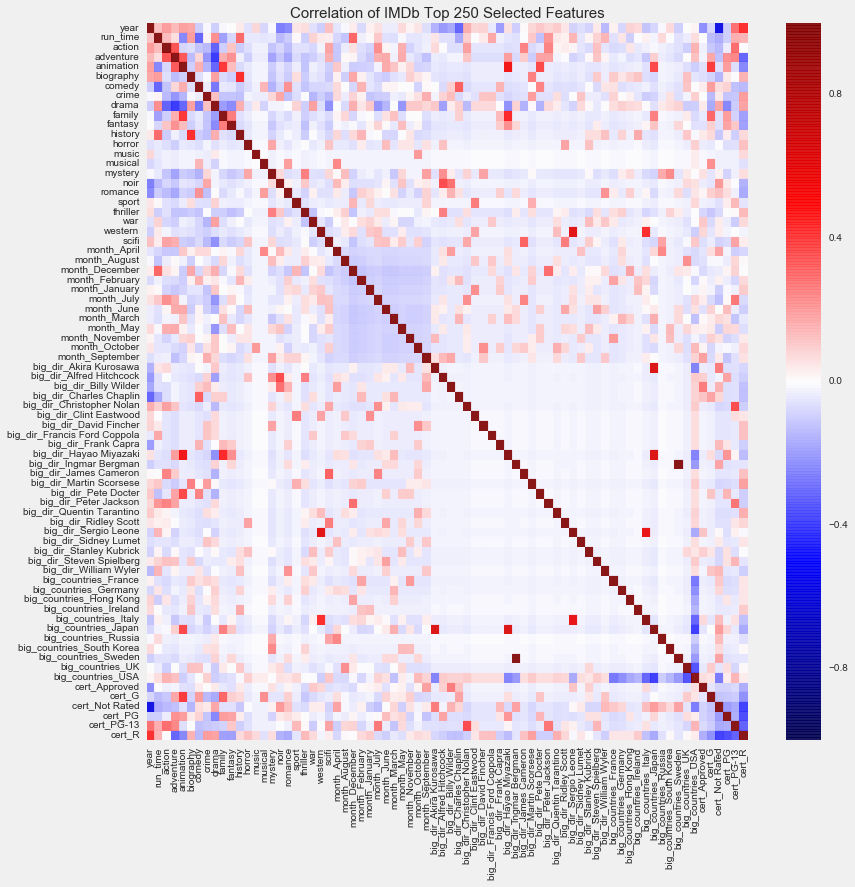

In [271]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.0)
ax = sns.heatmap(X_scaled.ix[:, 1:len(X_scaled.columns)].corr(), \
                 cmap = "seismic", alpha = 0.9)

ax.axes.set_title("Correlation of IMDb Top 250 Selected Features", size = 15)

plt.show()

A couple interesting observations from this plot are that animations are big in Japan, Docter and Miyazaki are probably best-known for their animated features, and Westerns are big in Italy!

Set up plot parameters:

In [272]:
n = 242
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return   

In [273]:
dt = DecisionTreeRegressor()

scores = cross_val_score(dt, X_scaled, y, cv=cv)
scores.mean()

0.18595041322314049

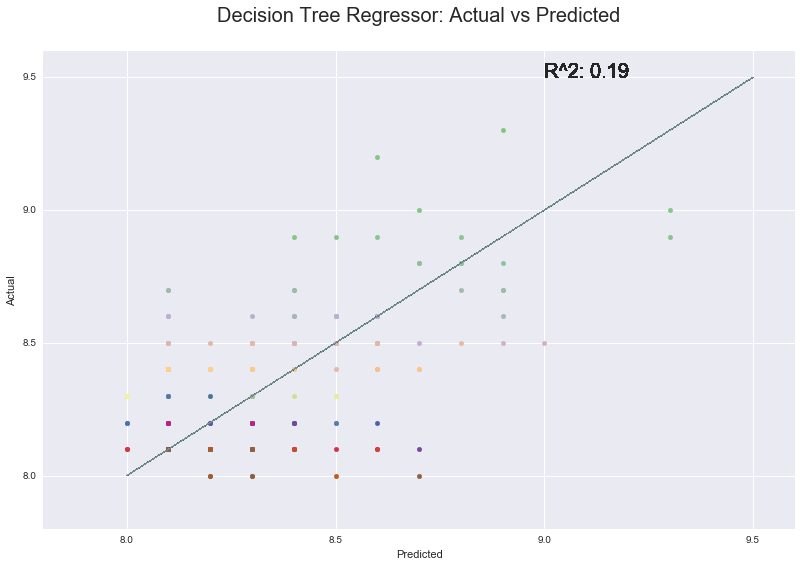

In [274]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(dt, scores.mean().round(2))

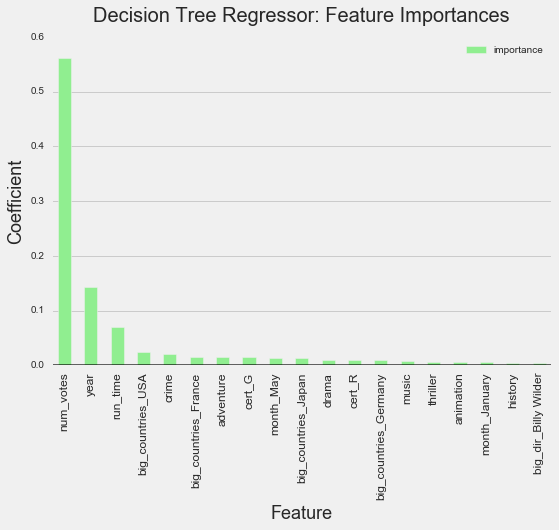

In [326]:
dt.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), \
                      X_scaled.columns), reverse=True)
features_dt = pd.DataFrame(features, columns = ['importance', 'feature'])
features_dt = features_dt.sort_values(by = 'importance', ascending = False)
features_dt = features_dt.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_dt[0:19].plot.bar(color = 'lightgreen')

plt.title('Decision Tree Regressor: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 12)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [327]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(rf, X_scaled, y, cv=cv)
scores.mean()

0.0

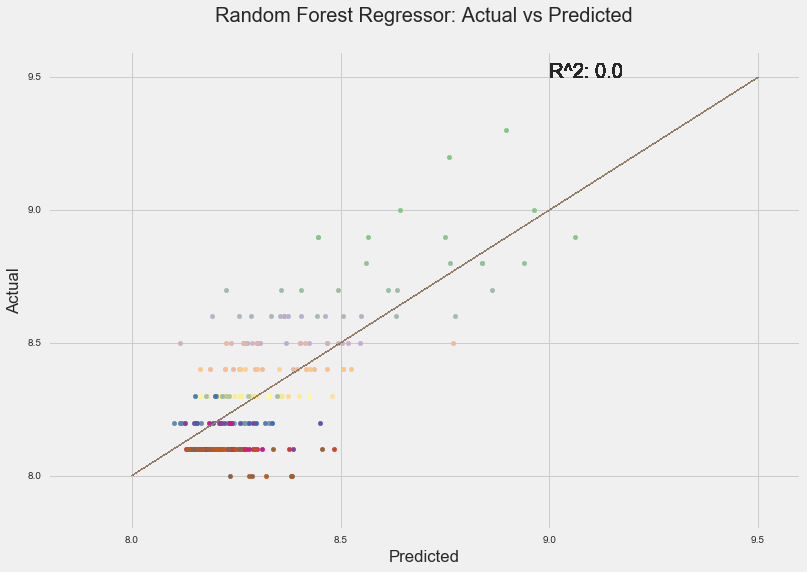

In [328]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(rf, scores.mean().round(2))

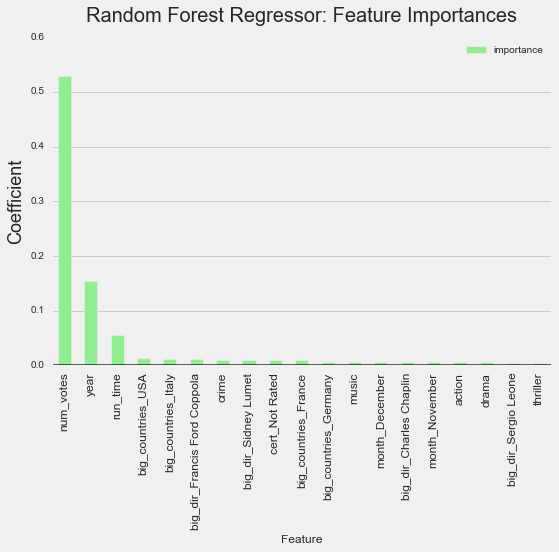

In [330]:
rf.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_scaled.columns), 
             reverse=True)
features_rf = pd.DataFrame(features, columns = ['importance', 'feature'])
features_rf = features_rf.sort_values(by = 'importance', ascending = False)
features_rf = features_rf.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_rf[0:19].plot.bar(color = 'lightgreen')

plt.title('Random Forest Regressor: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 12)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 12)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [332]:
ab = AdaBoostRegressor(n_estimators = 100)

scores = cross_val_score(ab, X_scaled, y, cv=cv)
scores.mean()

0.016528925619834711

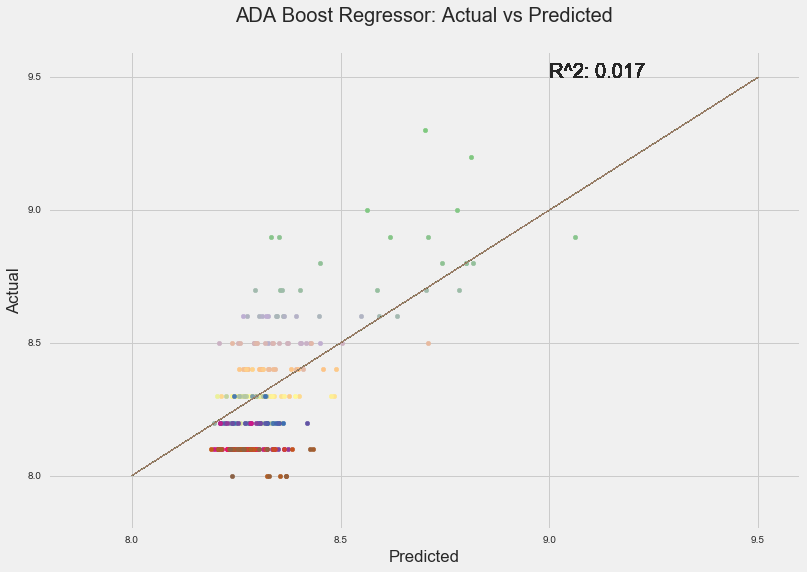

In [333]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ADA Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(ab, scores.mean().round(3))

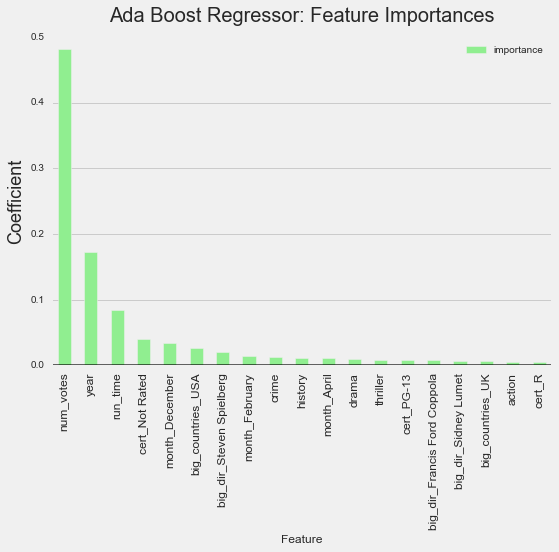

In [334]:
ab.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), ab.feature_importances_), X_scaled.columns), 
             reverse=True)
features_ab = pd.DataFrame(features, columns = ['importance', 'feature'])
features_ab = features_ab.sort_values(by = 'importance', ascending = False)
features_ab = features_ab.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_ab[0:19].plot.bar(color = 'lightgreen')

plt.title('Ada Boost Regressor: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 12)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 12)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [335]:
gb = GradientBoostingRegressor(n_estimators = 100)

scores = cross_val_score(gb, X_scaled, y, cv=cv)
scores.mean()

0.0

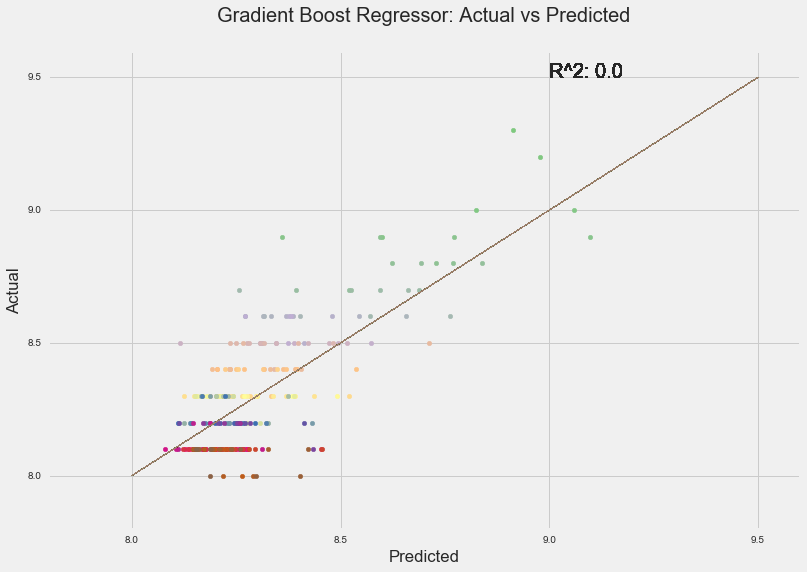

In [336]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(gb, scores.mean().round(2))

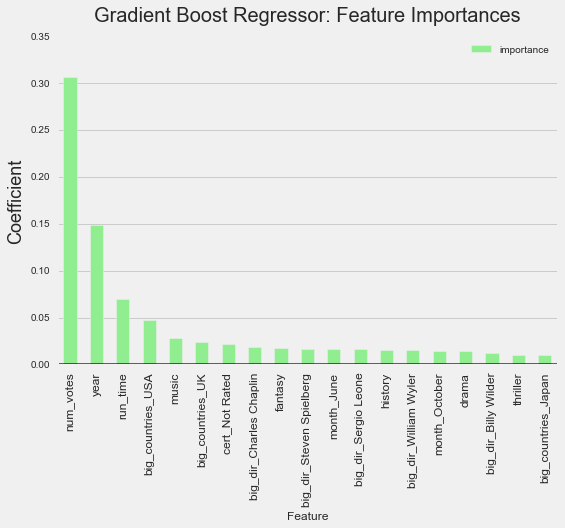

In [337]:
gb.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), gb.feature_importances_), X_scaled.columns), 
             reverse=True)
features_gb = pd.DataFrame(features, columns = ['importance', 'feature'])
features_gb = features_gb.sort_values(by = 'importance', ascending = False)
features_gb = features_gb.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_gb[0:19].plot.bar(color = 'lightgreen')

plt.title('Gradient Boost Regressor: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 12)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 12)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [338]:
et = ExtraTreesRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(et, X_scaled, y, cv=cv)
scores.mean()

0.0

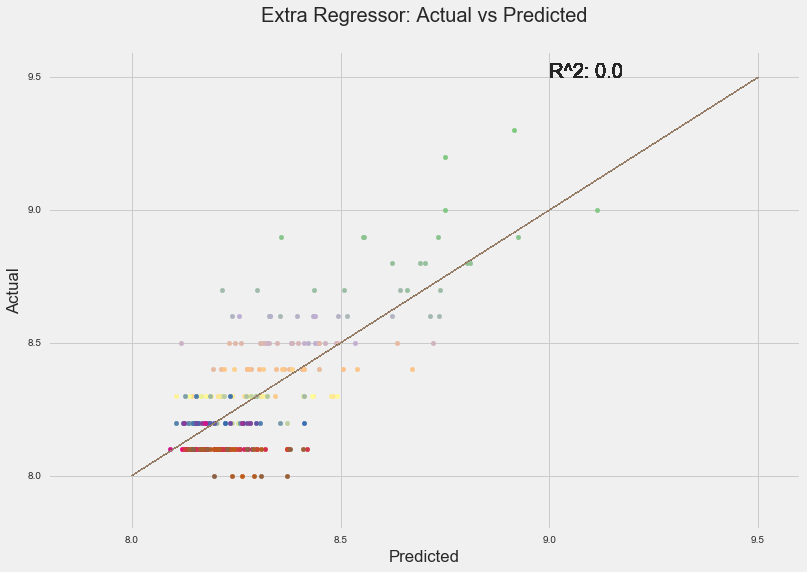

In [339]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Extra Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(et, scores.mean().round(2))

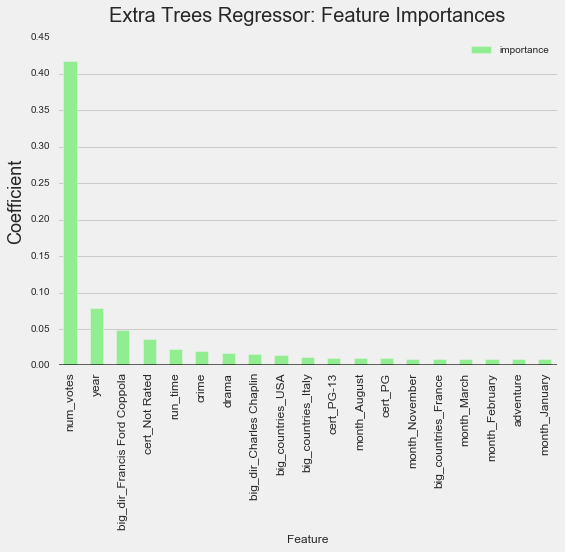

In [340]:
et.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), et.feature_importances_), X_scaled.columns), 
             reverse=True)
features_et = pd.DataFrame(features, columns = ['importance', 'feature'])
features_et = features_et.sort_values(by = 'importance', ascending = False)
features_et = features_et.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_et[0:19].plot.bar(color = 'lightgreen')

plt.title('Extra Trees Regressor: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 12)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 12)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [341]:
bagger = BaggingRegressor(DecisionTreeRegressor())

scores = cross_val_score(bagger, X_scaled, y, cv=cv)
scores.mean()

0.0082644628099173556

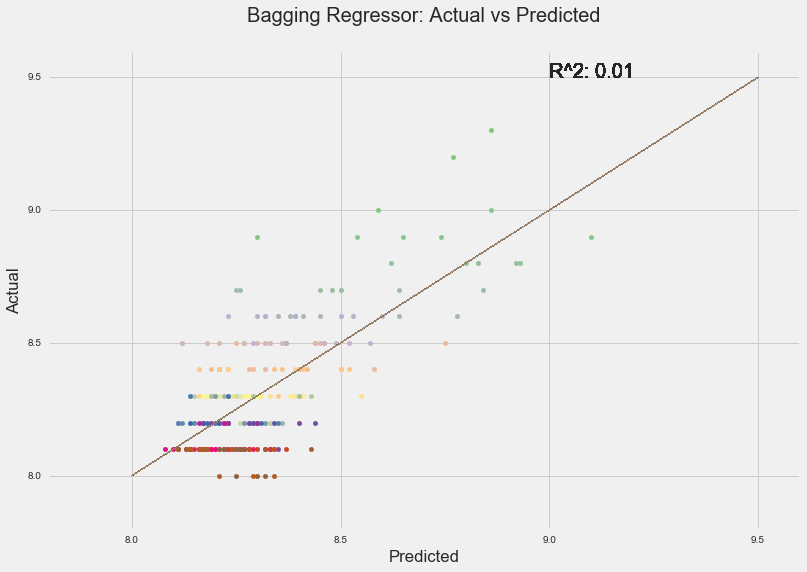

In [342]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Bagging Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(bagger, scores.mean().round(2))

In [495]:
def get_score(model, name):
    score = cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1)
    print('{} Score:\t{:0.3} ± {:0.3}'.format(name, score.mean().round(3), \
                                              score.std().round(3)))
    
pairs = {
    'Decision Tree' : dt,
    'Bagging' : bagger,
    'Random Forest' : rf,
    'Extra Trees' : et,
    'Ada Booster' : ab,
    'Gradient Booster' : gb
}

for key in list(pairs.keys()):
    get_score(pairs[key], key)

Bagging Score:	0.025 ± 0.155
Extra Trees Score:	0.0 ± 0.0
Decision Tree Score:	0.182 ± 0.386
Gradient Booster Score:	0.0 ± 0.0
Ada Booster Score:	0.012 ± 0.111
Random Forest Score:	0.0 ± 0.0


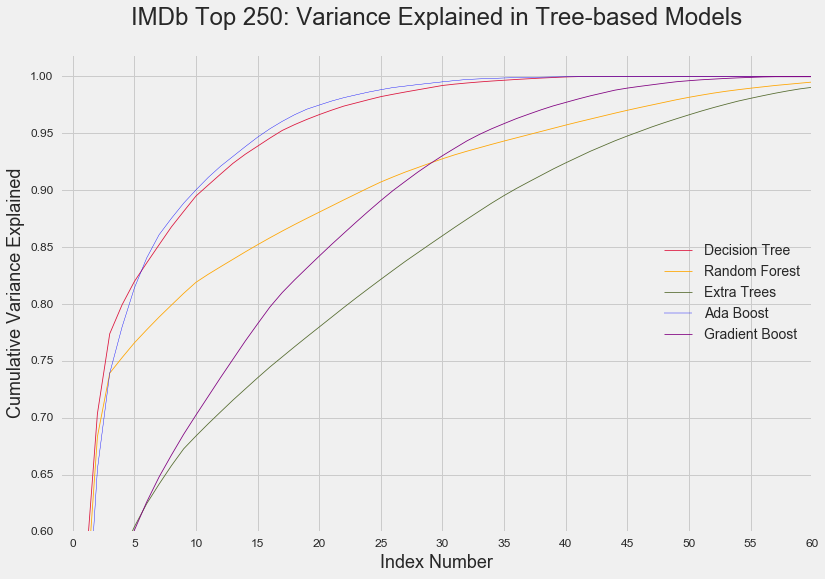

In [357]:
def TheAccumulator(df):
    cumulative = []
    total = 0
    for i in range(len(df)):
        cumulative.append(total)
        total += df['importance'][i]
    df['sum'] = cumulative
    df = df.reset_index(drop = True)
    return df

features_dt = TheAccumulator(features_dt)
features_et = TheAccumulator(features_et)
features_gb = TheAccumulator(features_gb)
features_ab = TheAccumulator(features_ab)
features_rf = TheAccumulator(features_rf)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.plot(features_dt.index, features_dt['sum'], color = 'Crimson', linewidth = 0.8, \
         label = 'Decision Tree')
plt.plot(features_rf.index, features_rf['sum'], color = 'Orange', linewidth = 0.8, \
         label = 'Random Forest')
plt.plot(features_et.index, features_et['sum'], color = 'DarkOliveGreen', linewidth = 0.8, \
         label = 'Extra Trees')
plt.plot(features_ab.index, features_ab['sum'], color = 'blue', linewidth = 0.4, \
         label = 'Ada Boost')
plt.plot(features_gb.index, features_gb['sum'], color = 'purple', linewidth = 0.8, \
         label = 'Gradient Boost')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('IMDb Top 250: Variance Explained in Tree-based Models', fontsize = 24, y = 1.05)

# y label
plt.ylabel('Cumulative Variance Explained', fontsize = 18)
plt.yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05], fontsize = 12)

# x label
plt.xlabel('Index Number', y = 0.1, fontsize = 18)
plt.xticks(range(0, 65, 5), fontsize = 12)

plt.xlim([-1, 60])
plt.ylim([0.6, 1.02])
plt.legend(loc='center right', fontsize = 14)

plt.show()

Looks like ADA Boost Regressor is the way to go with this data set!  Let's dig deeper...

Now let's only consider movies post-1962, since right around then seems to have been a turning point in terms of user rating behavior on IMDb:

In [358]:
new_top = big_top[big_top['year'] > 1962]

Let's check out a scatterplot of runtime vs number of votes since we only looked at a box and whisker plot before:

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


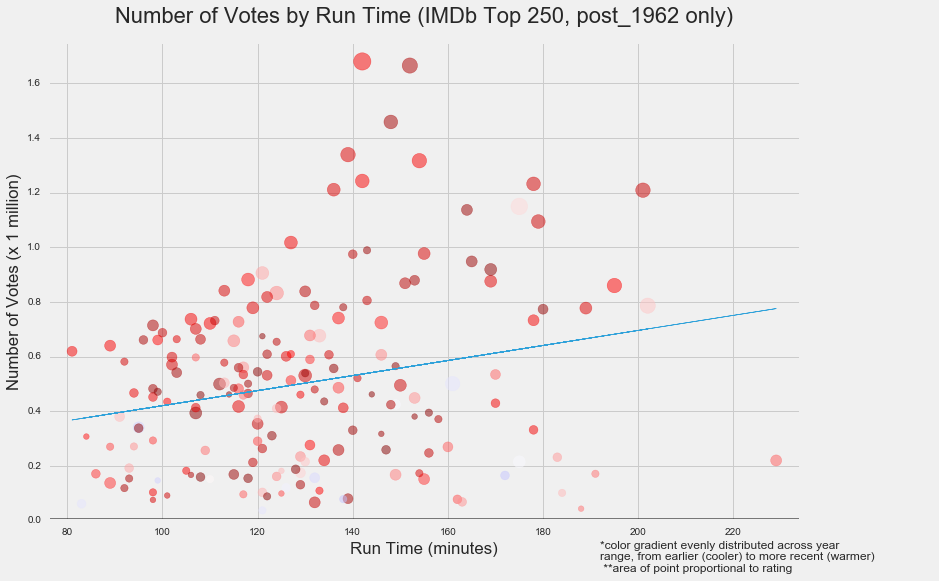

In [359]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

top_year_color = []
count = 0
for i in new_top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
new_top['top_year_color'] = top_year_color

plt.scatter(new_top['run_time'], new_top['num_votes']/1000000, \
            color = new_top['top_year_color'], alpha = 0.5, s = area)

plt.title('Number of Votes by Run Time (IMDb Top 250, post_1962 only)', fontsize = 22, y = 1.03)
plt.axhline(0, color='black', alpha = 0.5)

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Run Time (minutes)')

# set the figure boundaries
plt.xlim([min(new_top['run_time'])-5, max(new_top['run_time'])+5])
plt.ylim([0, 1.75])
plt.grid(True)
plt.annotate('*color gradient evenly distributed across year \nrange, from earlier (cooler) to more recent (warmer)\
                 \n **area of point proportional to rating', (1,0), (-200, -20), \
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

m, b = np.polyfit(new_top['run_time'], new_top['num_votes']/1000000, 1)

plt.plot(new_top['run_time'], m*new_top['run_time'] + b, '-', linewidth = 0.7)

plt.show()

Check if any columns sum to zero since we took out 1962.  If so, remove them:

In [501]:
for i in new_top.columns:
    if new_top[i].sum() == 0:
        print '\n'
        print i
    else:
        print '.',

. . . . . . . . . . . . . . . . 

musical
. 

noir
. . . . . . . . . . . . . . . . . . . 

big_dir_Alfred Hitchcock


big_dir_Billy Wilder


big_dir_Charles Chaplin
. . . . 

big_dir_Frank Capra
. . . . . . . . . . . . 

big_dir_William Wyler
. . . . . . . . . . . . . . .


In [502]:
del new_top['musical']
del new_top['noir']
del new_top['big_dir_Alfred Hitchcock']
del new_top['big_dir_Billy Wilder']
del new_top['big_dir_Charles Chaplin']
del new_top['big_dir_Frank Capra']
del new_top['big_dir_William Wyler']
del new_top['top_year_color']

In [503]:
X_post62 = pd.DataFrame(new_top.ix[:, 1:len(new_top.columns)], \
                        columns = new_top.columns[1:len(new_top.columns)])
Xs = MinMaxScaler().fit_transform(X_post62.astype(float))
Xs = pd.DataFrame(Xs, columns = X_post62.columns[0:len(new_top.columns)])
y_new = new_top.ix[:,0]
len(Xs.columns)

65

In [504]:
Xs.head(1)

,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,drama,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,1.0,0.584906,0.412162,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [505]:
n = len(Xs)
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X_post62), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return  

In [506]:
dt = DecisionTreeRegressor()

scores = cross_val_score(dt, Xs, y_new, cv=cv)
scores.mean()

0.11956521739130435

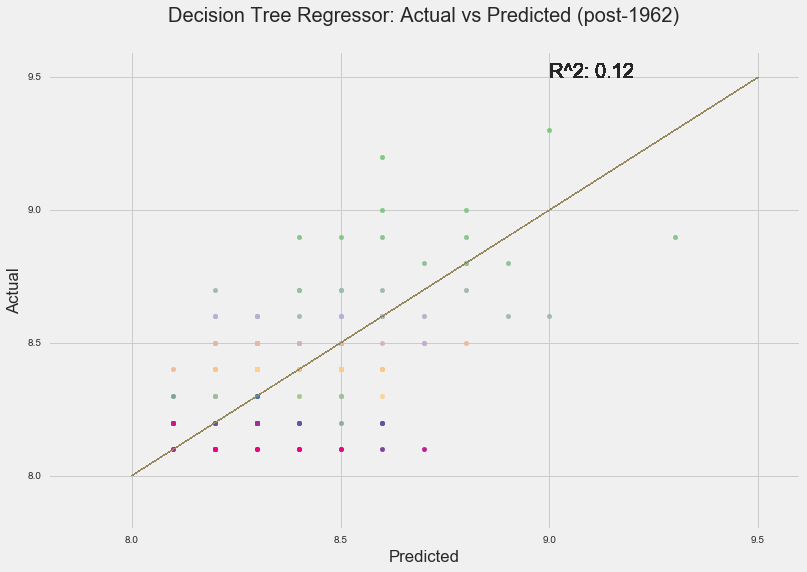

In [507]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(dt, scores.mean().round(2))

In [508]:
dt.fit(Xs, y_new)
features = sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), Xs.columns), 
             reverse=True)
features_dt = pd.DataFrame(features, columns = ['importance', 'feature'])
features_dt = features_dt.sort('importance', ascending = False)
features_dt = features_dt.set_index('feature', drop = True)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



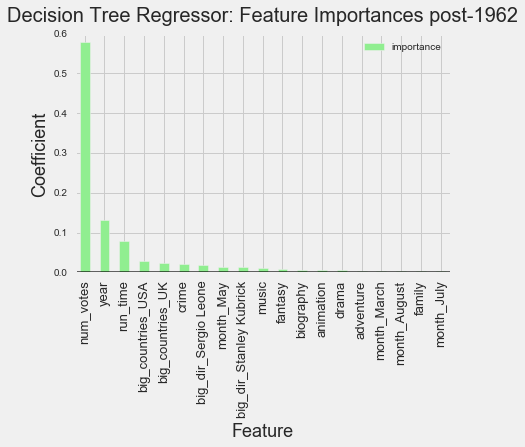

In [510]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_dt[0:19].plot.bar(color = 'lightgreen')

plt.title('Decision Tree Regressor: Feature Importances post-1962', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 13)
plt.show()

In [511]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(rf, Xs, y_new, cv=cv)
scores.mean()

0.0

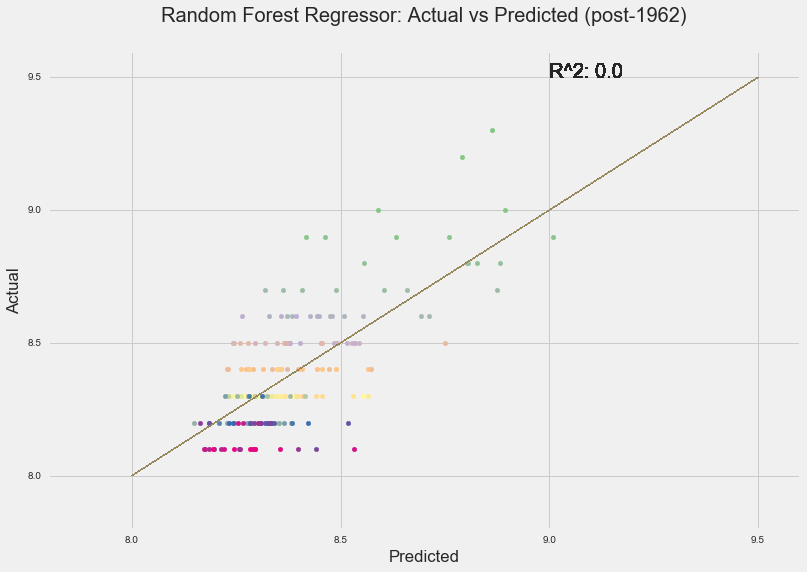

In [512]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(rf, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



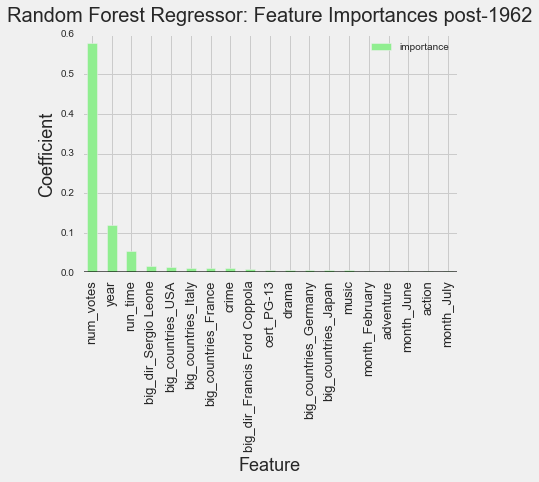

In [516]:
rf.fit(Xs, y_new)
features = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), Xs.columns), 
             reverse=True)
features_rf = pd.DataFrame(features, columns = ['importance', 'feature'])
features_rf = features_rf.sort('importance', ascending = False)
features_rf = features_rf.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_rf[0:19].plot.bar(color = 'lightgreen')

plt.title('Random Forest Regressor: Feature Importances post-1962', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=90, fontsize = 13)
plt.show()

In [517]:
et = ExtraTreesRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(et, Xs, y_new, cv=cv)
scores.mean()

0.0

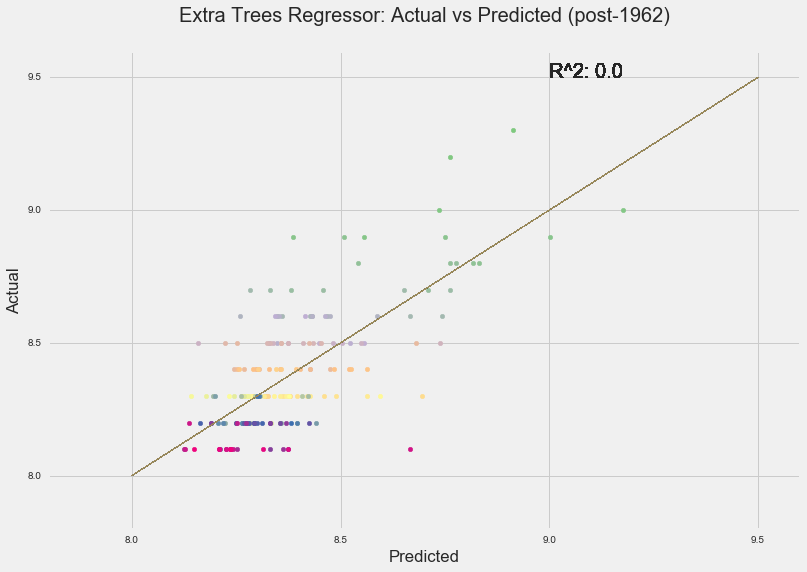

In [518]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Extra Trees Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(et, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



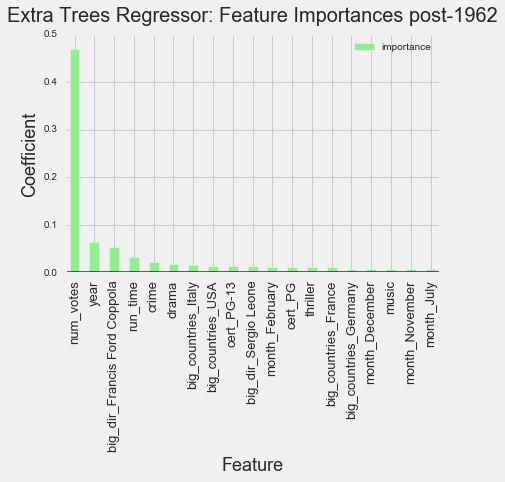

In [519]:
et.fit(Xs, y_new)
features = sorted(zip(map(lambda x: round(x, 4), et.feature_importances_), Xs.columns), 
             reverse=True)
features_et = pd.DataFrame(features, columns = ['importance', 'feature'])
features_et = features_et.sort('importance', ascending = False)
features_et = features_et.set_index('feature', drop = True)


plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_et[0:19].plot.bar(color = 'lightgreen')

plt.title('Extra Trees Regressor: Feature Importances post-1962', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=90, fontsize = 13)
plt.show()

In [520]:
ab = AdaBoostRegressor(n_estimators = 100)

scores = cross_val_score(ab, Xs, y_new, cv=cv)
scores.mean()

0.016304347826086956

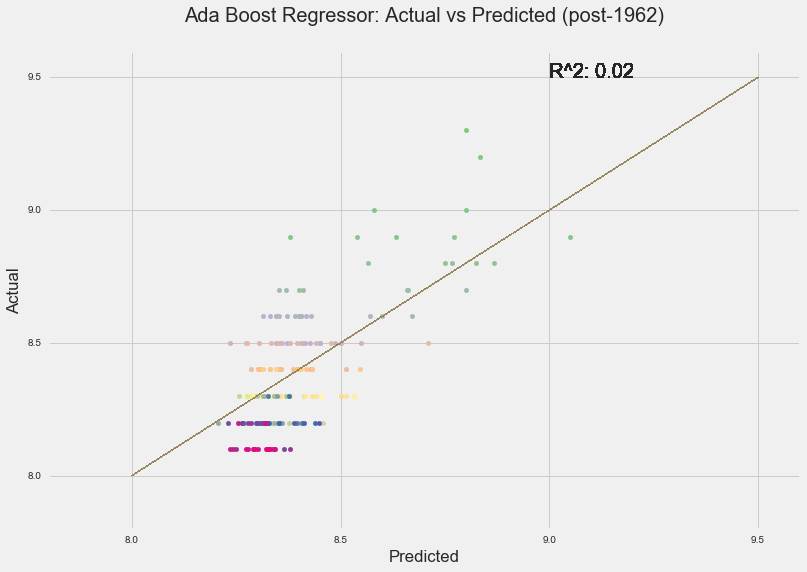

In [521]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ada Boost Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(ab, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



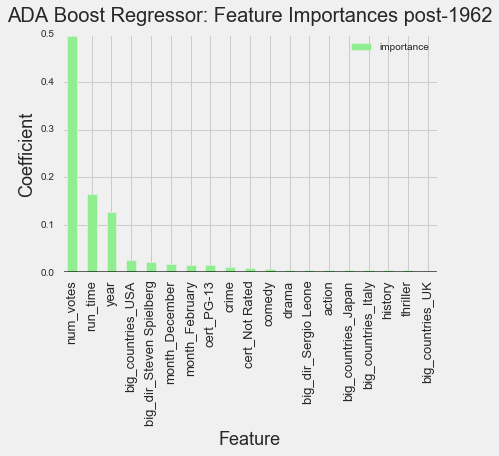

In [522]:
ab.fit(Xs, y_new)
features = sorted(zip(map(lambda x: round(x, 4), ab.feature_importances_), Xs.columns), 
             reverse=True)
features_ab = pd.DataFrame(features, columns = ['importance', 'feature'])
features_ab = features_ab.sort('importance', ascending = False)
features_ab = features_ab.set_index('feature', drop = True)


plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_ab[0:19].plot.bar(color = 'lightgreen')

plt.title('ADA Boost Regressor: Feature Importances post-1962', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=90, fontsize = 13)
plt.show()

In [523]:
gb = GradientBoostingRegressor(n_estimators = 100)

scores = cross_val_score(gb, Xs, y_new, cv=cv)
scores.mean()

0.0

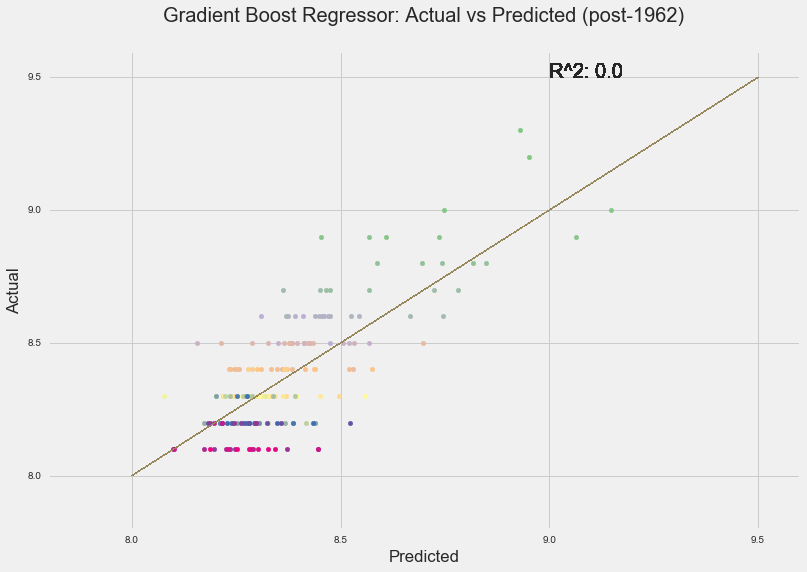

In [524]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(gb, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



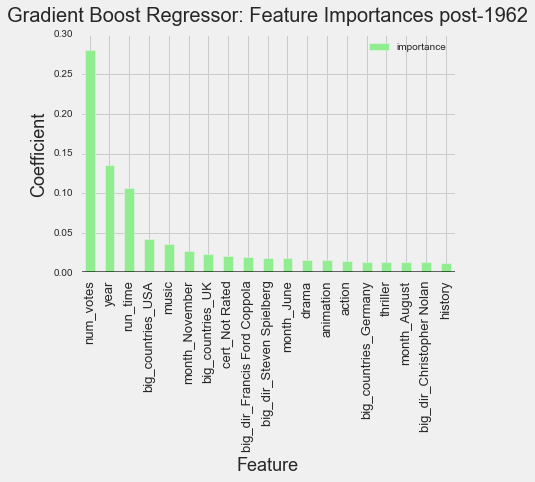

In [525]:
gb.fit(Xs, y_new)
features = sorted(zip(map(lambda x: round(x, 4), gb.feature_importances_), Xs.columns), 
             reverse=True)
features_gb = pd.DataFrame(features, columns = ['importance', 'feature'])
features_gb = features_gb.sort('importance', ascending = False)
features_gb = features_gb.set_index('feature', drop = True)


plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_gb[0:19].plot.bar(color = 'lightgreen')

plt.title('Gradient Boost Regressor: Feature Importances post-1962', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=90, fontsize = 13)
plt.show()

In [526]:
bagger = BaggingRegressor(DecisionTreeRegressor())

scores = cross_val_score(bagger, Xs, y_new, cv=cv)
scores.mean()

0.016304347826086956

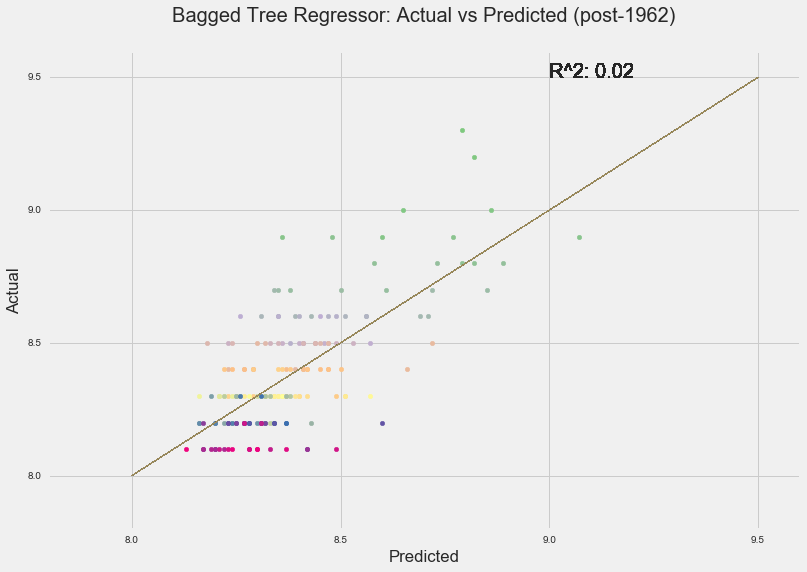

In [527]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Bagged Tree Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(bagger, scores.mean().round(2))

In [528]:
def get_score(model, name):
    score = cross_val_score(model, Xs, y_new, cv = cv, n_jobs = -1)
    print('{} Score:\t{:0.3} ± {:0.3}'.format(name, score.mean().round(3), score.std().round(3)))
    
pairs = {
    'Decision Tree' : dt,
    'Bagging' : bagger,
    'Random Forest' : rf,
    'Extra Trees' : et,
    'Ada Booster' : ab,
    'Gradient Booster' : gb
}

for key in list(pairs.keys()):
    get_score(pairs[key], key)

Bagging Score:	0.005 ± 0.074
Extra Trees Score:	0.0 ± 0.0
Decision Tree Score:	0.152 ± 0.359
Gradient Booster Score:	0.0 ± 0.0
Ada Booster Score:	0.0 ± 0.0
Random Forest Score:	0.0 ± 0.0


In [529]:
def TheAccumulator(df):
    cumulative = []
    total = 0
    for i in range(len(df)):
        cumulative.append(total)
        total += df['importance'][i]
    df['sum'] = cumulative
    df = df.reset_index(drop = True)
    return df

features_dt = TheAccumulator(features_dt)
features_et = TheAccumulator(features_et)
features_gb = TheAccumulator(features_gb)
features_ab = TheAccumulator(features_ab)
features_rf = TheAccumulator(features_rf)

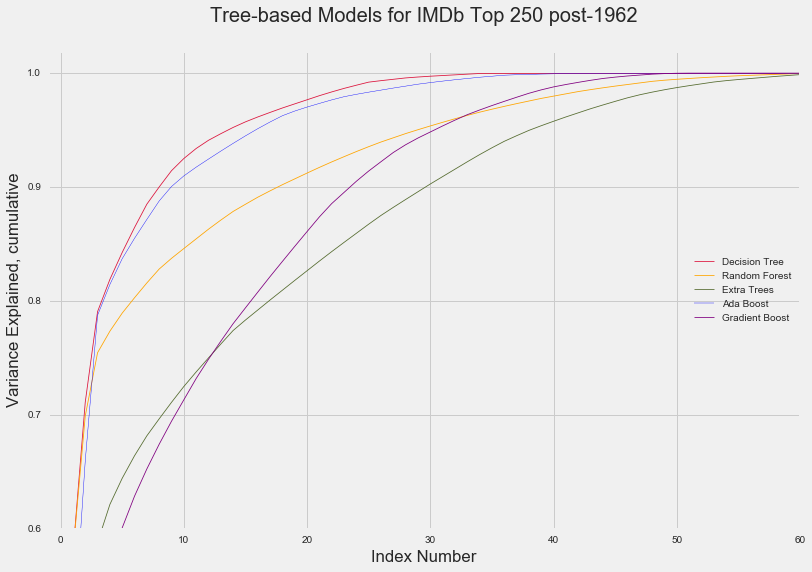

In [530]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.plot(features_dt.index, features_dt['sum'], color = 'Crimson', linewidth = 0.8, label = 'Decision Tree')
plt.plot(features_rf.index, features_rf['sum'], color = 'Orange', linewidth = 0.8, label = 'Random Forest')
plt.plot(features_et.index, features_et['sum'], color = 'DarkOliveGreen', linewidth = 0.8, label = 'Extra Trees')
plt.plot(features_ab.index, features_ab['sum'], color = 'blue', linewidth = 0.4, label = 'Ada Boost')
plt.plot(features_gb.index, features_gb['sum'], color = 'purple', linewidth = 0.8, label = 'Gradient Boost')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('Tree-based Models for IMDb Top 250 post-1962', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Variance Explained, cumulative')

# x label
plt.xlabel('Index Number', y = 0.1)

plt.xlim([-1, 60])
plt.ylim([0.6, 1.02])
plt.legend(loc='center right')

plt.show()

As we can see from changes in the histograms of feature importance, once we remove pre-1962 movies from the data set, vote count becomes more important, while year becomes less so.  This makes sense intuitively, since we know that older movies have fewer votes on average and the number of votes for newer movies is increasingly spread out.  Refer to the Rating vs Number of Votes plot (blue-to-red dots, by year) to illustrate this point; if you take out all the blue points, the variance in remaining dots becomes larger (i.e., number of votes is an even more significant predictive feature).  Along these same lines, once the older movies are removed, year of release is a less significant feature.

Let's do a classifier now; classifications will be encoded by tenths place from 8.0 to 9.3:

In [531]:
encoder = LabelEncoder()
fit = encoder.fit(y_new)
y_cats = encoder.transform(y_new)

Here are some functions we will need shortly:

In [532]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels = ['8.1', '8.2', '8.3', '8.4',\
                                                    '8.5', '8.6', '8.7', '8.8', '8.9', '9.0', '9.1', '9.2', '9.3']):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline
    return

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return

Here are our train/test splits:

In [533]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y_cats, test_size=0.33, random_state=42)

Let's test the classifier models in the same order as corresponding regression models above:

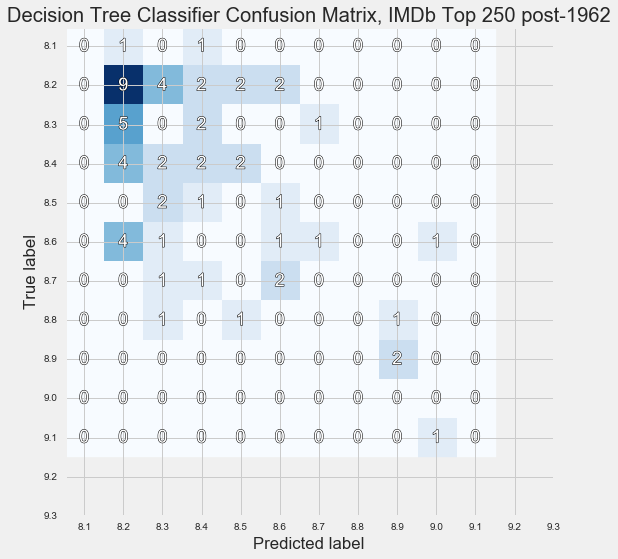

In [534]:
dtc = DecisionTreeClassifier()

y_pred = dtc.fit(X_train, y_train).predict(X_test)

pred1 = dtc.predict_proba(X_train).T[1]

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, title='Decision Tree Classifier Confusion Matrix, IMDb Top 250 post-1962')

In [535]:
print 'Decision Tree Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Decision Tree Classifier:
accuracy: 0.229508196721
precision: 0.2020274016
recall: 0.229508196721


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



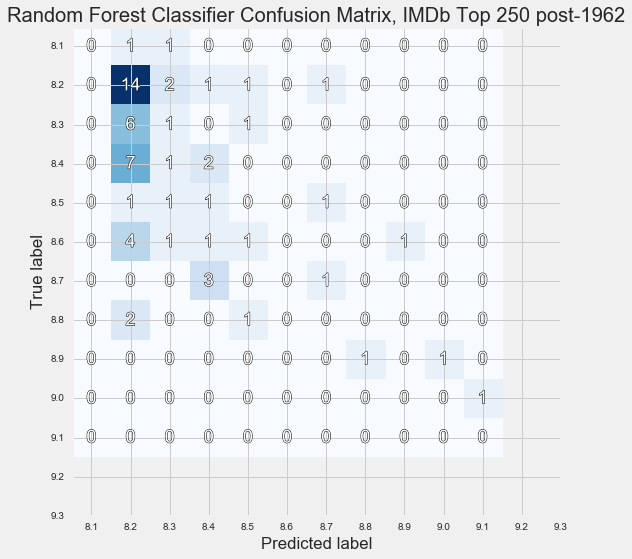

In [536]:
rfc = RandomForestClassifier()

y_pred = rfc.fit(X_train, y_train).predict(X_test)

pred1 = rfc.predict_proba(X_train).T[1]

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, title='Random Forest Classifier Confusion Matrix, IMDb Top 250 post-1962')

In [537]:
print 'Random Forest Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Random Forest Classifier:
accuracy: 0.295081967213
precision: 0.206167056987
recall: 0.295081967213


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



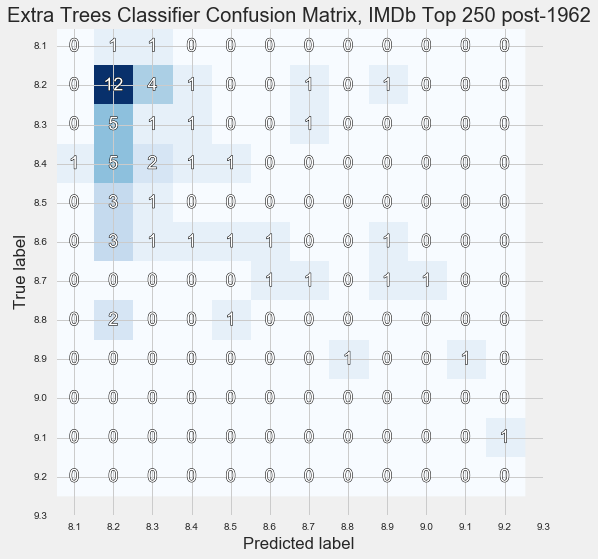

In [538]:
etc = ExtraTreesClassifier()

y_pred = etc.fit(X_train, y_train).predict(X_test)

pred1 = etc.predict_proba(X_train).T[1]

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, title='Extra Trees Classifier Confusion Matrix, IMDb Top 250 post-1962')

In [539]:
print 'Extra Trees Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Extra Trees Classifier:
accuracy: 0.262295081967
precision: 0.262101181033
recall: 0.262295081967


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



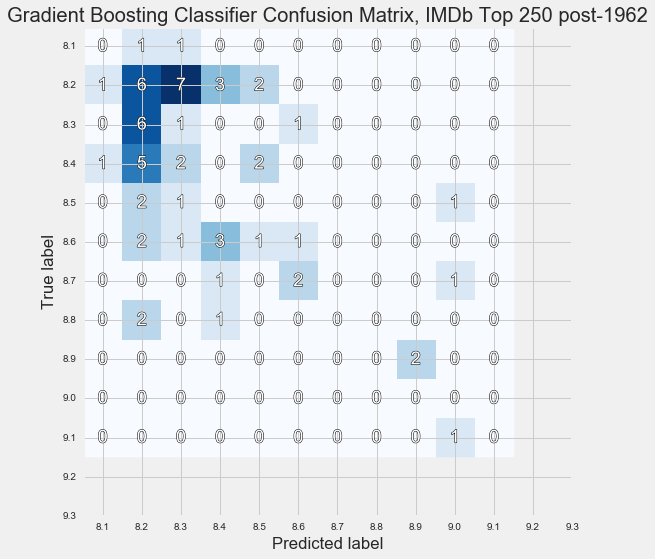

In [540]:
gbc = GradientBoostingClassifier()

y_pred = gbc.fit(X_train, y_train).predict(X_test)

pred1 = gbc.predict_proba(X_train).T[1]

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, title='Gradient Boosting Classifier Confusion Matrix, IMDb Top 250 post-1962')

In [541]:
print 'Gradient Boosting Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Gradient Boosting Classifier:
accuracy: 0.16393442623
precision: 0.153530895334
recall: 0.16393442623


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



Extra Trees Classifier looks like our best option, here!  Not perfect, obviously, but it's getting a lot of 8.2 ratings correct and slightly overrating some of them.  We can pick a model based on what our preferences are for accuracy/recall/precision but that looks like the best one overall.

As it stands, number of votes, runtime, and year of release are the most important features in predicting user rating using these tree-based models.  In terms of further analysis, we could consider taking into account leading actors (and supporting ones!), language of release, cost of acquisition to Netflix, etc.  To pick which model to use for prediction we should further discuss the cost to the company of misclassifying a movie's rating.